In [1]:
import pandas as pd
import fasttext
import numpy as np
import string
import re
from collections import Counter

#NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer


#Sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import LatentDirichletAllocation as LDA,TruncatedSVD, PCA, SparsePCA, NMF
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score, pairwise_distances, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets 

#from jqmcvi import base

from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import spacy
#import en_core_web_sm
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#Visualization
from pprint import pprint
import matplotlib.gridspec as gridspec
import plotly
import plotly.express as px
import upsetplot
import seaborn as sns
from wordcloud import WordCloud, get_single_color_func
from matplotlib_venn import venn2, venn2_circles

In [2]:
# Get to know default colours
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [3]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [4]:
def lemmatize(l):
    lemmatizer = WordNetLemmatizer()
    res = []
    for el in l:
        res.append(lemmatizer.lemmatize(el[0], pos = get_wordnet_pos(el[1])))
    return res

In [5]:
# function to plot the histogram of the given dataframe.
def make_density(df,color, x_axis_text, y_axis_text, bins, x, y=None, kde=True, rp=2, show_mean=False, show_other=False, show_quant=False, quant_val=0.95):
    
    sns.set_context(rc = {'edgecolor':color})
    # Draw the histogram and fit a density plot.
    ax = sns.histplot(df,x=x, bins=bins, kde=kde,
                      line_kws={'linewidth': 2}, color=color)
    if show_mean:
        # compute mode of the histogram.
        mean_x = round(df[x].mean(), rp)
        
        if rp==0:
            mean_x = int(mean_x)

        # draw a vertical line at the mode of the histogram.
        ax.axvline(mean_x, color='orange', linestyle='dashed', linewidth=1.5)
        ax.text(mean_x+0.1*mean_x, ax.get_ylim()[1]/2, '$\mu = {}$'.format(mean_x,rp))
    if show_other:
        std_x = round(df[x].std(), rp)
        med_x = round(df[x].median(),rp)
        min_x = round(df[x].min(), rp)
        max_x = round(df[x].max(), rp)
        if rp==0:
            std_x = int(std_x)
            min_x = int(min_x)
            max_x = int(max_x)
            med_x = int(med_x)
    if show_quant:
        quant_x = round(df[x].quantile(quant_val), rp)
        if rp==0:
            quant_x = int(quant_x)
    if show_other & show_quant:
        ax.set_title('$\sigma = {}$ | $median = {}$ | $min = {}$ | $max = {}$ | ${} percentile={}$'.format(std_x,med_x,min_x,max_x,quant_val,quant_x))
    elif show_other:
        ax.set_title('$\sigma = {}$ | $median = {}$ | $min = {}$ | $max = {}$'.format(std_x,med_x,min_x,max_x,quant_val))
    # Plot formatting
    ax.set_xlabel(x_axis_text)
    ax.set_ylabel(y_axis_text)
    return ax

In [6]:
skills = pd.read_csv('skills_clusters.csv',encoding='utf-8',engine ='python')

In [7]:
skills.head()

idc_personid_ext       dta_created_on  idc_sk_skills  \
0          61002457  2019-04-24 08:40:13   516853876-63   
1          61002457  2019-04-24 08:40:13   516853876-63   
2          61002457  2019-04-24 08:40:13   516853876-63   
3          61002457  2019-04-24 08:40:13   516853876-63   
4                11  2019-03-19 17:05:42  1540288815-19   

                                      sds_skill_name  \
0  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
1  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
2  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
3  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
4                                GESTION DE PERSONAS   

                    skill_split                     skill_en cluster  \
0  cunostinte avansate computer  advanced computer knowledge     345   
1                        retele                      network     257   
2                   telecontrol                       remote     597   
3                  automatizari                   automation     112   
4           gestion de personas            people management     119   

                            cluster_label  \
0                  information technology   
1  infrastructure and network competences   
2                       remote management   
3                       automation system   
4                       people management   

                      cluster_macro_label          dta_process  
0  information technology and programming  2020-03-06 09:55:03  
1                      engineering skills  2020-03-06 09:55:03  
2                       managerial skills  2020-03-06 09:55:03  
3                      engineering skills  2020-03-06 09:55:03  
4                       managerial skills  2020-03-06 09:55:03

In [8]:
print('Number of empty macro cluster labels: '+ str(len(skills[skills['cluster_macro_label'].isnull()])))
print('Number of skills macro cluster labels: '+ str(skills['cluster_macro_label'].nunique()))

print('Number of empty clusters: '+ str(len(skills[skills['cluster'].isnull()])))
print('Number of skills clusters: '+ str(skills['cluster'].nunique()))
print('Number of empty cluster labels: '+ str(len(skills[skills['cluster_label'].isnull()])))
print('Number of skills cluster labels: '+ str(skills['cluster_label'].nunique()))

print('Number of empty skills: '+ str(len(skills[skills['skill_en'].isnull()])))
print('Number of skills: '+ str(skills['skill_en'].nunique()))

print('Number of empty employee_id: '+ str(len(skills[skills['idc_personid_ext'].isnull()])))
print('Number of employee id: '+ str(skills['idc_personid_ext'].nunique()))

Number of empty macro cluster labels: 0
Number of skills macro cluster labels: 18
Number of empty clusters: 0
Number of skills clusters: 4778
Number of empty cluster labels: 0
Number of skills cluster labels: 298
Number of empty skills: 1107
Number of skills: 44667
Number of empty employee_id: 0
Number of employee id: 35430


In [9]:
#Delete rows with empty skills
skills.dropna(axis=0, how='any', subset=['skill_en'], inplace=True)

In [10]:
# Check that all the skills are written in lower case
skills.loc[skills['skill_en'].apply(lambda x: x.islower()==False).to_list(),:]

Empty DataFrame
Columns: [idc_personid_ext, dta_created_on, idc_sk_skills, sds_skill_name, skill_split, skill_en, cluster, cluster_label, cluster_macro_label, dta_process]
Index: []

In [246]:
#skills['skill_en'] = skills['skill_en'].apply(lambda x: x.lower())
#skills['skill_list'] = skills['skill_en'].apply(lambda x: x.split())
#skills['skill_pos'] = skills['skill_list'].apply(nltk.pos_tag)
#skills['skill_en_lem']=skills['skill_pos'].apply(lemmatize).apply(lambda x: ' '.join(x))

In [247]:
skills['cluster_macro_label'].unique()

array(['information technology and programming', 'engineering skills',
       'managerial skills', 'personal skills', 'other', 'economic skills',
       'teamwork', 'energy related skills', 'interpersonal skills',
       'office related skills', 'foreign languages', 'healt and safety',
       'scientific skills', 'technical skills', 'legal skills',
       'hobby related skills', 'security', 'drivers related skills'],
      dtype=object)

In [11]:
skills.cluster_macro_label = skills.cluster_macro_label.replace({"information technology and programming": "it"})

In [12]:
# Different levels of aggregation

# Number of employees per cluster (Skill subtype)
skills_subtype_empl = (skills.groupby('cluster_label')['idc_personid_ext'].nunique().reset_index())

# Number of clusters (Skill subtype) per macro cluster (Skill type)
clust_per_macro_clust = (skills.groupby('cluster_macro_label')['cluster_label'].nunique().reset_index()).rename(columns={'cluster_label':'count'})

# Number of employees per Skill type and Skill subtype
cluster_hierarchy = pd.DataFrame({'#Employees' : skills.groupby( ['cluster_macro_label','cluster_label'] ).idc_personid_ext.nunique()}).reset_index()

# Number of skills per Skill type and Skill subtype
cluster_hierarchy_skill = pd.DataFrame({'#Skills' : skills.groupby( ['cluster_macro_label','cluster_label'] ).skill_en.nunique()}).reset_index()

# Number of employees per macro cluster (Skill type)
empl_macro_clust = (skills.groupby('cluster_macro_label')['idc_personid_ext'].nunique()
       #.apply(lambda x: ' '.join(set(x.dropna())))
       .reset_index())

#Number of skills per employee
empl_skills = (skills.groupby('idc_personid_ext')['skill_en'].nunique()
       #.apply(lambda x: ' '.join(set(x.dropna())))
       .reset_index())

#Number of Skill types (macro clusters) per employee
empl_skill_type = (skills.groupby('idc_personid_ext')['cluster_macro_label'].nunique()
       #.apply(lambda x: ' '.join(set(x.dropna())))
       .reset_index())


#Number of employee per skill
skills_empl_num = (skills.groupby('skill_en')['idc_personid_ext'].nunique()
       #.apply(lambda x: ' '.join(set(x.dropna())))
       .reset_index())

In [250]:
# Prepare data for bubble plot of number of Skill subtype per Skill type
clust_per_macro_clust['size'] = clust_per_macro_clust['count']*100 # Bubble size
clust_per_macro_clust['label'] = clust_per_macro_clust['cluster_macro_label'] +' (' + clust_per_macro_clust['count'].apply(lambda x: str(x)) +')' #Label
clust_per_macro_clust = clust_per_macro_clust[list(('cluster_macro_label','count', 'size', 'label'))] #Column order

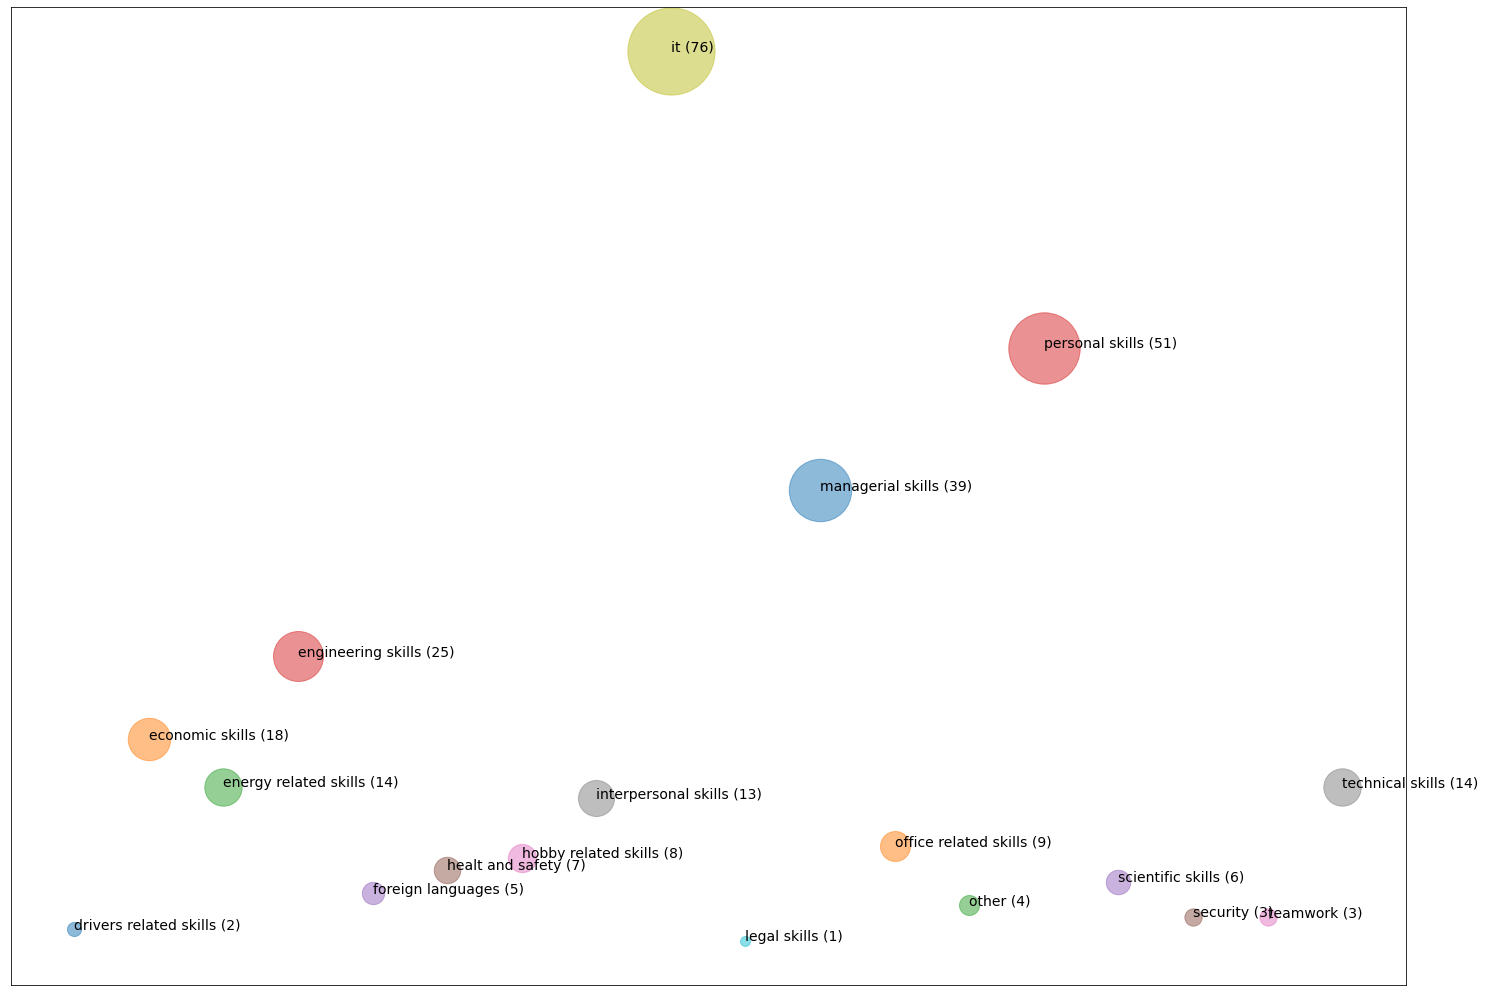

In [251]:
fig, ax = plt.subplots(facecolor='w', figsize=(25,18))
for key, row in clust_per_macro_clust.iterrows():
    ax.scatter(row['cluster_macro_label'], row['count'], s=row['size'], alpha=.5)
    ax.annotate(row['label'], xy=(row['cluster_macro_label'], row['count']),fontsize=14)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\Skill_subtype_per_Skill_type.png")

In [252]:
# Number of employees per macro cluseter(SKill type) and cluster(Skill subtype)
#cluster_hierarchy = pd.DataFrame({'#Employees' : skills.groupby( ['cluster_macro_label','cluster_label'] ).idc_personid_ext.nunique()}).reset_index()
fig = px.treemap(cluster_hierarchy, path=['cluster_macro_label', 'cluster_label'], values='#Employees',
                  color='#Employees', hover_data=['#Employees'],
                  color_continuous_scale='Blues')
fig.show()
plotly.offline.plot(fig, filename="D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\clusters_per_macro_cluster_heat_map.html")

'D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\clusters_per_macro_cluster_heat_map.html'

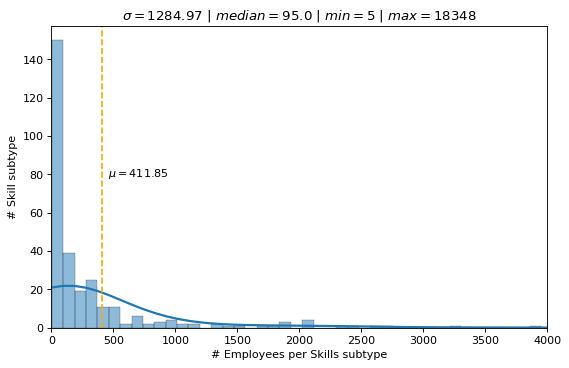

In [254]:
#
fig = plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=skills_subtype_empl, color='#1f77b4',x_axis_text='# Employees per Skills subtype', y_axis_text='# Skill subtype',
                  bins=200, x='idc_personid_ext', y=None, kde=True, show_mean=True, show_other=True)
plt.xlim(0,4000)
plt.show()
#fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\empl_per_skill_subtype.png")

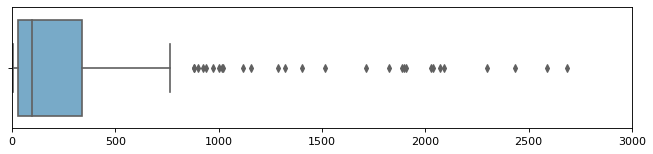

In [255]:
fig = plt.figure(figsize=(10,2),dpi=80)
ax = sns.boxplot(x=skills_subtype_empl['idc_personid_ext'], palette = "Blues",  showfliers=True) #,
plt.xlim(0,3000)
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

In [256]:
skills_subtype_empl['idc_personid_ext'].describe()

count      298.000000
mean       411.848993
std       1284.968556
min          5.000000
25%         30.000000
50%         95.000000
75%        340.500000
max      18348.000000
Name: idc_personid_ext, dtype: float64

In [257]:
def check_val(in_list, cols):
    '''
    Function which creates a boolean list with values True on the positions on which in input list are
    strings from input list cols.
    Args: 
        in_list: list of strings
        cols: list of strings
    Returns: 
        res_list: Boolean list of the same length as cols
    '''
    
    res_list = [False]*len(list(cols))
    
    idx = ([i for i, e in enumerate(cols) if e in in_list])
    target = [True]*len(idx)
    for x,y in zip(idx,target):
        res_list[x] = y
    return res_list

In [258]:
#Preparing dataset for UpSetPlot https://ieeexplore.ieee.org/document/6876017

# Create df which contains per each employee list of macro clusters (Skill type) from which he has at least one skill
group = (skills.loc[:,['idc_personid_ext', 'cluster_macro_label']]).groupby('idc_personid_ext')

df = group.apply(lambda x: x['cluster_macro_label'].unique()).reset_index().rename(columns={0:'macro_cluster_list'})

#List of all macro clusters (SKill type) which will be used as column names in UpSetPlot df
cols = list(skills.cluster_macro_label.unique())
#Create boolean list
#At the position of each Skill type place True if employee has a skill from that type, otherwise False
df['macro_clust_list_all'] = df['macro_cluster_list'].apply(lambda x: check_val(list(x), cols))
df.head()

idc_personid_ext                                 macro_cluster_list  \
0                11        [managerial skills, personal skills, other]   
1                12               [managerial skills, personal skills]   
2                20  [other, managerial skills, engineering skills,...   
3                25        [managerial skills, other, personal skills]   
4                26   [interpersonal skills, other, managerial skills]   

                                macro_clust_list_all  
0  [False, False, True, True, True, False, False,...  
1  [False, False, True, True, False, False, False...  
2  [False, True, True, False, True, True, False, ...  
3  [False, False, True, True, True, False, False,...  
4  [False, False, True, False, True, False, False...

In [259]:
upset_df = pd.DataFrame(df.macro_clust_list_all.tolist(), index= df.index, columns=cols)
upset_df['c'] = 1
upset_df = upset_df.groupby(cols).count().sort_values('c', ascending=False)
upset_df.head()

c
it    engineering skills managerial skills personal skills other economic skills teamwork energy related skills interpersonal skills office related skills foreign languages healt and safety scientific skills technical skills legal skills hobby related skills security drivers related skills      
False False              False             False           True  False           False    False                 False                False                 False             False            False             False            False        False                False    False                   3702
      True               False             False           False False           False    False                 False                False                 False             False            False             False            False        False                False    False                   2374
True  False              False             False           False False           False    False                 False                False                 False             False            False             False            False        False                False    False                   2269
False False              False             True            False False           False    False                 False                False                 False             False            False             False            False        False                False    False                   1408
True  False              False             False           True  False           False    False                 False                False                 False             False            False             False            False        False                False    False                   1302

In [260]:
# Top 30 combinations
example = upset_df.iloc[0:30,:]

<Figure size 1440x2160 with 0 Axes>

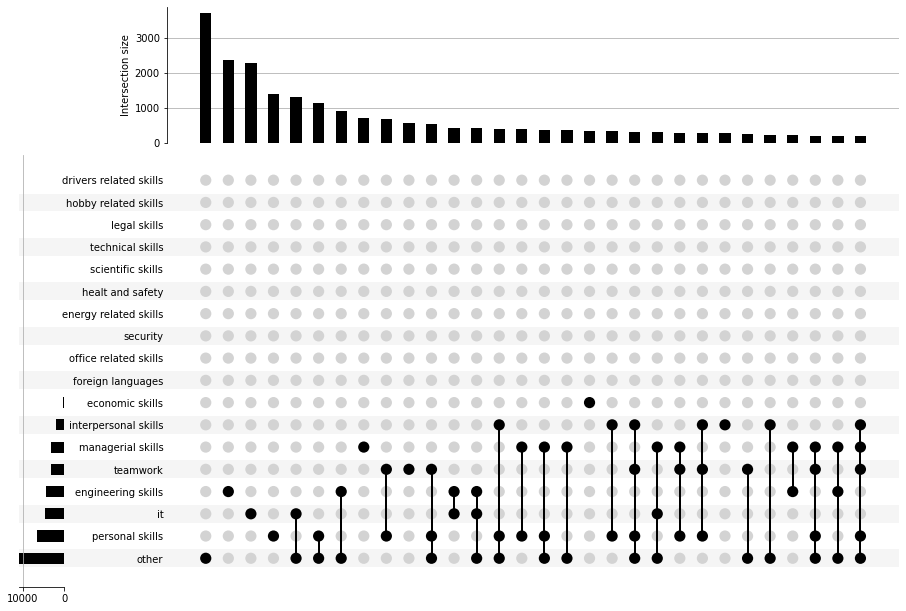

In [261]:
# Plot 30 most common Skill type combinations with frequency
fig = plt.figure(figsize=(20,30))
upsetplot.plot(example['c'], sort_by="cardinality", show_counts=False)
#fig = ax.get_figure()
plt.show()
#fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\Skill_type_comb.png")

In [263]:
empl_skills.describe()

idc_personid_ext      skill_en
count      3.527700e+04  35277.000000
mean       3.064794e+07      4.397653
std        1.606029e+07      4.284402
min        1.100000e+01      1.000000
25%        2.206268e+07      1.000000
50%        2.701472e+07      3.000000
75%        3.702423e+07      6.000000
max        9.370014e+07    122.000000

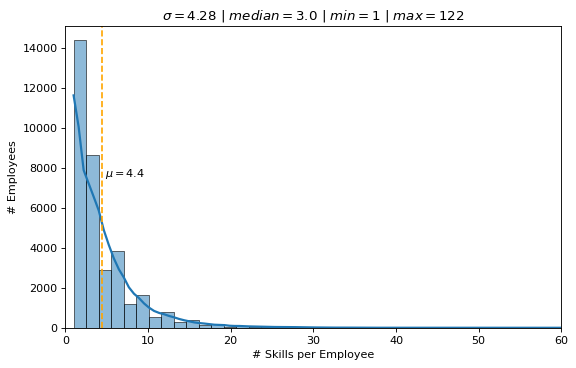

In [264]:
plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=empl_skills, color='#1f77b4',x_axis_text='# Skills per Employee', y_axis_text='# Employees', bins=80, 
             x='skill_en', y=None, kde=True, rp=2, show_mean=True, show_other=True)
plt.xlim(0,60)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\skills_per_empl.png")

In [265]:
skills_empl_num.describe()

idc_personid_ext
count      44667.000000
mean           3.473168
std           33.563064
min            1.000000
25%            1.000000
50%            1.000000
75%            1.000000
max         3645.000000

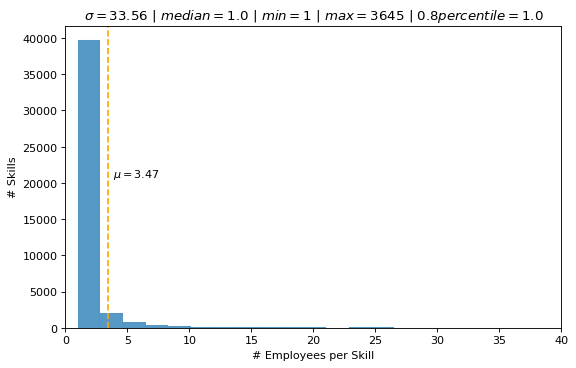

In [266]:
plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=skills_empl_num, color='#1f77b4',x_axis_text='# Employees per Skill', y_axis_text='# Skills', bins=2000, 
             x='idc_personid_ext', y=None, kde=False, show_mean=True, show_other=True, show_quant=True, quant_val=0.8)
plt.xlim(0,40)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\Empl_per_skill.png")

In [267]:
skills_empl_num['idc_personid_ext'].quantile(0.8)

1.0

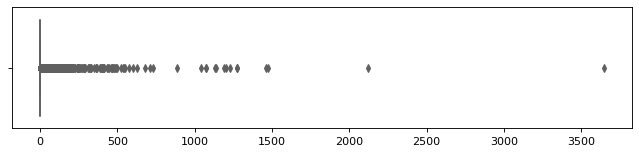

In [268]:
fig = plt.figure(figsize=(10,2),dpi=80)
ax = sns.boxplot(x=skills_empl_num['idc_personid_ext'], palette = "Blues",  showfliers=True) #,
#plt.xlim(0,3000)
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

### Text analysis

In [13]:
def create_ngram_dict(text,n=1,m=1):
    vec = CountVectorizer(ngram_range=(m, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    return words_dict

#### Words (unigrams)

In [14]:
skills_word_dict = create_ngram_dict(skills['skill_en'])

In [15]:
# Vocabulary size skills dataset
print('Vocabulary size of Employees\' Skills dataset: ' + str(len(skills_word_dict)))

Vocabulary size of Employees' Skills dataset: 12900


In [272]:
skills_word_dict

{'management': 13765,
 'work': 5624,
 'project': 4544,
 'microsoft': 4492,
 'teamwork': 4372,
 'excel': 4204,
 'knowledge': 4084,
 'word': 3861,
 'team': 3535,
 'maintenance': 3463,
 'system': 3454,
 'office': 3351,
 'network': 3194,
 'mt': 3155,
 'skill': 3121,
 'communication': 2981,
 'analysis': 2927,
 'electrical': 2844,
 'good': 2842,
 'planning': 2826,
 'bt': 2818,
 'sap': 2805,
 'ability': 2607,
 'problem': 2531,
 'control': 2472,
 'business': 2464,
 'power': 2439,
 'solve': 2084,
 'leadership': 2038,
 'technical': 1793,
 'energy': 1777,
 'process': 1751,
 'distribution': 1683,
 'operation': 1674,
 'organization': 1672,
 'design': 1652,
 'data': 1534,
 'customer': 1529,
 'responsibility': 1513,
 'plant': 1505,
 'capacity': 1497,
 'advance': 1458,
 'relationship': 1403,
 'proactivity': 1395,
 'engineering': 1386,
 'flexibility': 1339,
 'experience': 1321,
 'point': 1305,
 'pe': 1289,
 'outlook': 1284,
 'intermediate': 1270,
 'people': 1245,
 'tech': 1240,
 'remote': 1224,
 'chang

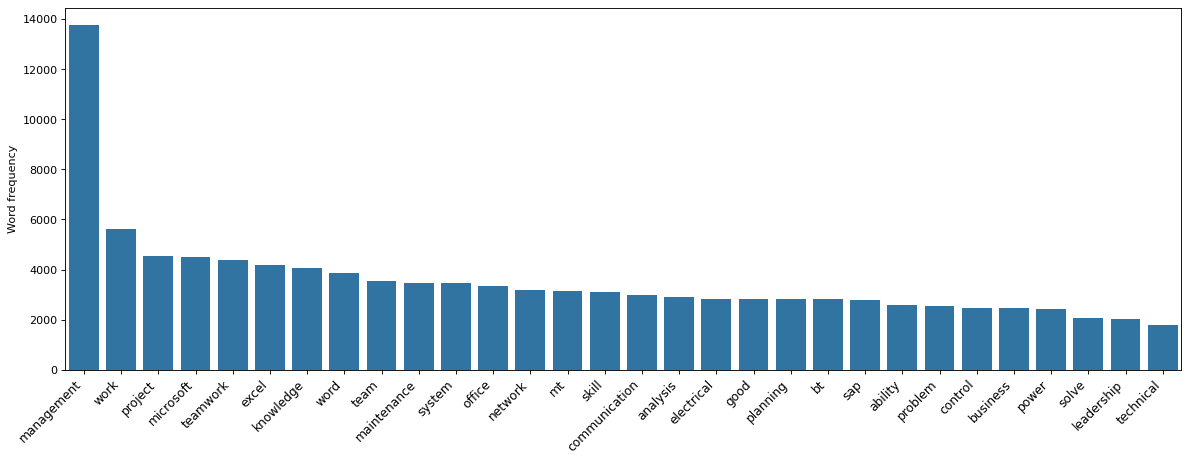

In [273]:
df = pd.DataFrame(list(skills_word_dict.items())[:30],
                             columns=['words', 'count'])
plt.figure(figsize=(18,6), dpi= 80)
ax = sns.barplot(x='words', y='count', data=df,color='#1f77b4')
#plt.xlim(0,4000)
# Plot formatting
ax.set_ylabel("Word frequency")
ax.set_xlabel("")

plt.xticks(rotation=45, ha='right',fontsize=11)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\top_30_freq_words.png")

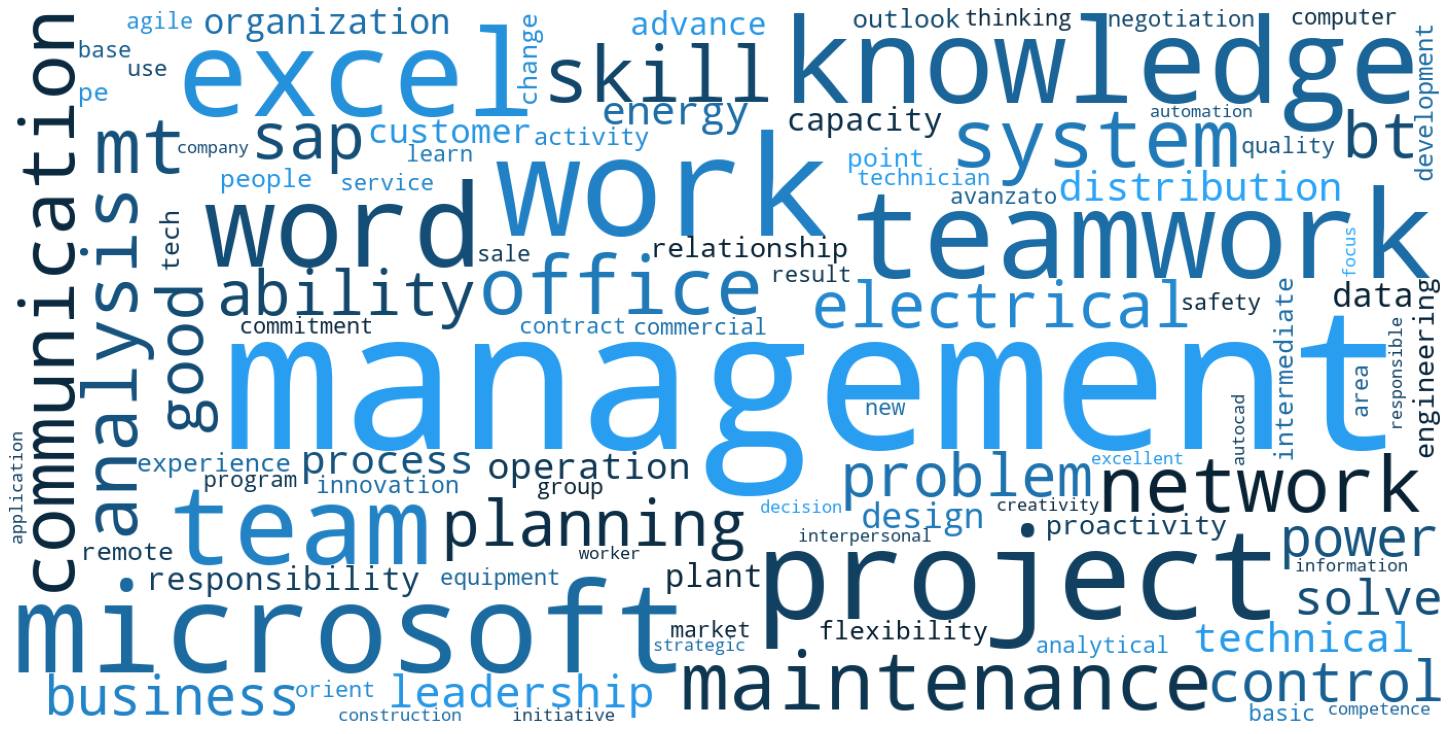

In [274]:
# Create a WordCloud object
wordcloud = WordCloud(width=1400, height=700, background_color="white", max_words=100, contour_width=3,color_func=get_single_color_func('#1f77b4')) #, contour_color='steelblue'
# Generate a word cloud
wordcloud.generate_from_frequencies(skills_word_dict)

# Visualize the word cloud
fig = plt.figure(figsize=(20,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\Wordcloud_skills.png")

#### Bigrams analysis

In [275]:
skills_bi_dict = create_ngram_dict(skills['skill_en'],2,2)

In [276]:
# Bigram vocabulary size skills dataset
print('Bigram vocabulary size of Employees\' Skills dataset: ' + str(len(skills_bi_dict)))

Bigram vocabulary size of Employees' Skills dataset: 66669


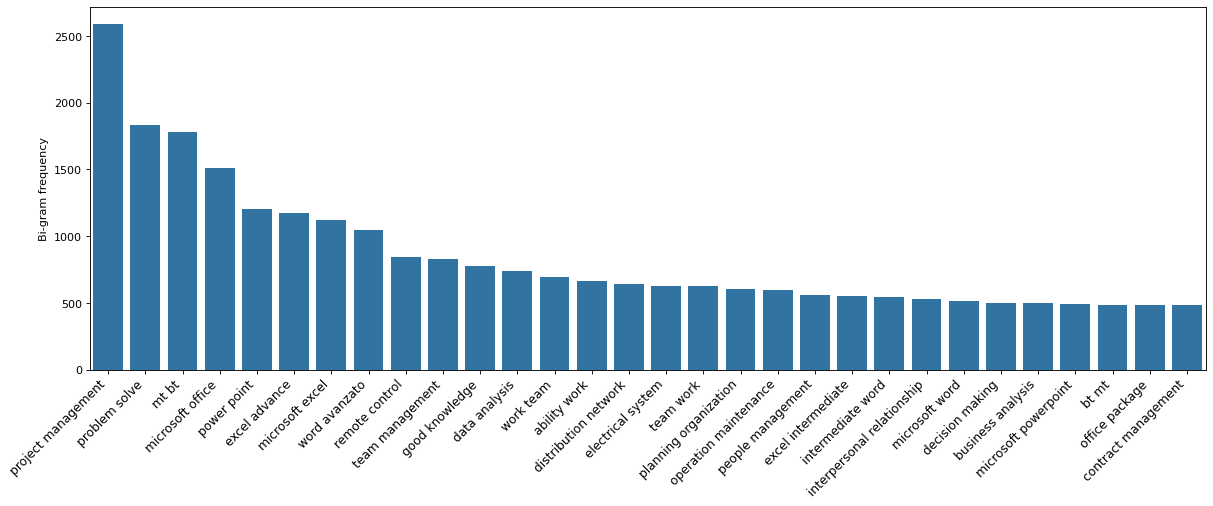

In [277]:
df = pd.DataFrame(list(skills_bi_dict.items())[:30],
                             columns=['bi-grams', 'count'])
plt.figure(figsize=(18,6), dpi= 80)
ax = sns.barplot(x='bi-grams', y='count', data=df,color='#1f77b4')
#plt.xlim(0,4000)
# Plot formatting
ax.set_ylabel("Bi-gram frequency")
ax.set_xlabel("")

plt.xticks(rotation=45, ha='right',fontsize=11)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\top_30_freq_bigrams.png")

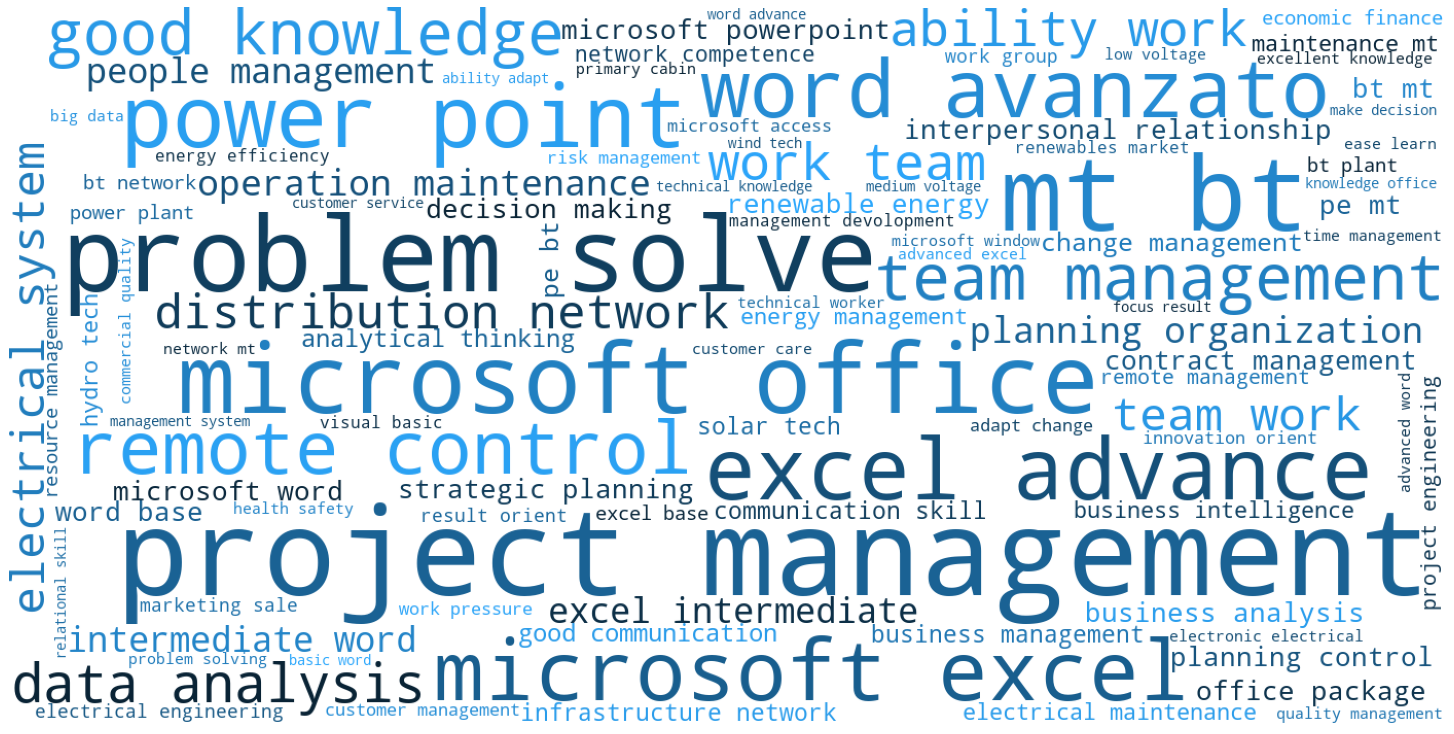

In [278]:
# Create a WordCloud object
wordcloud = WordCloud(width=1400, height=700, background_color="white", max_words=100, contour_width=3,color_func=get_single_color_func('#1f77b4')) #, contour_color='steelblue'
# Generate a word cloud
wordcloud.generate_from_frequencies(skills_bi_dict)

# Visualize the word cloud
fig = plt.figure(figsize=(20,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\Wordcloud_skills_bigrams.png")

#### Word distributions

In [16]:
# Create grouping of skills per employee
skills_empl = (skills.groupby('idc_personid_ext')['skill_en']
       .apply(lambda x: ' '.join(x.dropna()))
       .reset_index())
skills_empl['skill_list'] = skills_empl['skill_en'].apply(lambda x: x.split())
skills_empl['num_words'] = skills_empl['skill_list'].apply(lambda x: len(x))

In [280]:
skills_empl.head()

idc_personid_ext                                           skill_en  \
0                11  people management negotiation business orienta...   
1                12  customer management goal orient innovation ori...   
2                20  learn capability management operation maintena...   
3                25  team management result action orient problem s...   
4                26  effective communication transversal knowledge ...   

                                          skill_list  num_words  
0  [people, management, negotiation, business, or...          5  
1  [customer, management, goal, orient, innovatio...          8  
2  [learn, capability, management, operation, mai...          6  
3  [team, management, result, action, orient, pro...          9  
4  [effective, communication, transversal, knowle...          6

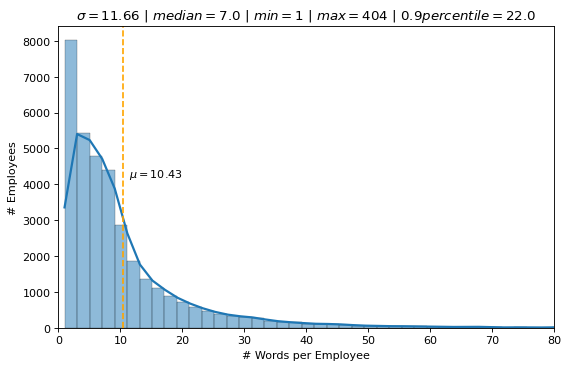

In [281]:
# Distribution of number of words per Employee
plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=skills_empl, color='#1f77b4',x_axis_text='# Words per Employee', y_axis_text='# Employees', bins=200, 
             x='num_words', y=None, kde=True, show_mean=True, show_other=True,show_quant=True, quant_val=0.9)
plt.xlim(0,80)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\words_per_empl.png")

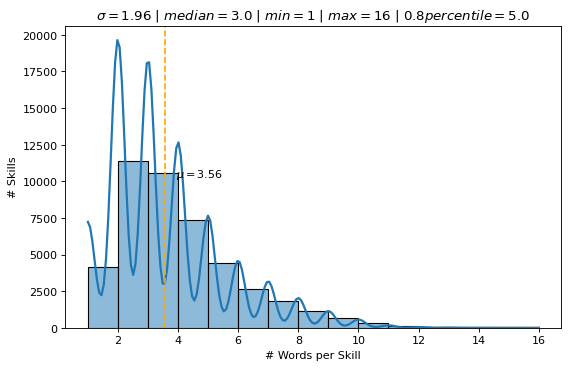

In [282]:
# Distribution of number of words per Skill
skills_empl_num['skill_list'] = skills_empl_num['skill_en'].apply(lambda x: x.split())
skills_empl_num['num_words'] = skills_empl_num['skill_list'].apply(lambda x: len(x))

plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=skills_empl_num, color='#1f77b4',x_axis_text='# Words per Skill', y_axis_text='# Skills', bins=15, 
             x='num_words', y=None, kde=True, show_mean=True, show_other=True,show_quant=True, quant_val=0.8)
#plt.xlim(0,100)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\words_per_skill.png")

In [283]:
skills.head()

idc_personid_ext       dta_created_on  idc_sk_skills  \
0          61002457  2019-04-24 08:40:13   516853876-63   
1          61002457  2019-04-24 08:40:13   516853876-63   
2          61002457  2019-04-24 08:40:13   516853876-63   
3          61002457  2019-04-24 08:40:13   516853876-63   
4                11  2019-03-19 17:05:42  1540288815-19   

                                      sds_skill_name  \
0  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
1  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
2  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
3  CUNOSTINTE AVANSATE COMPUTER, RETELE, TELECONT...   
4                                GESTION DE PERSONAS   

                    skill_split                     skill_en cluster  \
0  cunostinte avansate computer  advanced computer knowledge     345   
1                        retele                      network     257   
2                   telecontrol                       remote     597   
3                  automatizari                   automation     112   
4           gestion de personas            people management     119   

                            cluster_label cluster_macro_label  \
0                  information technology                  it   
1  infrastructure and network competences  engineering skills   
2                       remote management   managerial skills   
3                       automation system  engineering skills   
4                       people management   managerial skills   

           dta_process  
0  2020-03-06 09:55:03  
1  2020-03-06 09:55:03  
2  2020-03-06 09:55:03  
3  2020-03-06 09:55:03  
4  2020-03-06 09:55:03

In [284]:
# Create grouping of skills per Skill subtype
skills_subtype = (skills.groupby('cluster_label')['skill_en']
       .apply(lambda x: ' '.join(x.dropna()))
       .reset_index())
skills_subtype['skill_list'] = skills_subtype['skill_en'].apply(lambda x: x.split())
skills_subtype['num_words'] = skills_subtype['skill_list'].apply(lambda x: len(x))

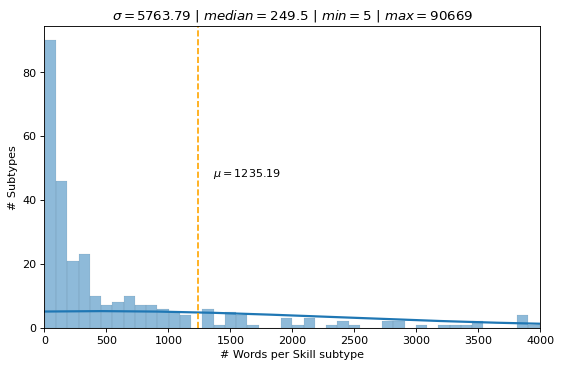

In [285]:
# Distribution of number of words per Skill subtype
plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=skills_subtype, color='#1f77b4',x_axis_text='# Words per Skill subtype', y_axis_text='# Subtypes', bins=1000, 
             x='num_words', y=None, kde=True, show_mean=True, show_other=True)
plt.xlim(0,4000)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Skills\\words_per_skill_subtype.png")

## Project Proposals dataset analysis

In [17]:
# Read preprocessed Project Proposals dataset
input_prj_en = pd.read_csv('Cleaned_input_text_all_words.csv')

In [18]:
input_prj_en.head()

Challenge: Challenge Title    Challenge Type  \
0  Are you an Enel employee? Propose your innovab...  I have a Project   
1             Enel X - POWERING UP NEW OPPORTUNITIES               NaN   
2  Mitigating the Environmental Impact of Large P...       InnoCentive   
3                         Enel Boston Innovation Hub               NaN   
4  Are you an individual innovator? Make your inn...  I have a Project   

  Solution: Created Date Solution: Solution Name  \
0             05/12/2018               SOL-27358   
1             11/05/2019               SOL-86113   
2             12/05/2019               SOL-86114   
3             12/05/2019               SOL-86115   
4             13/05/2019               SOL-86117   

                                               Title  \
0  Use of Plugin Office " Dictate". Dictate and d...   
1                              Better Vacuum Cleaner   
2  SOLAR FARM as GREENHOUSE AGRICULTURE or Short ...   
3                       Structural Health Monitoring   
4              Supplier Hunting for energy companies   

                                            Abstract  \
0  "Dictate". free open Plugin to add to Office p...   
1  To consume energy in an efficient manner by pr...   
2  SOLAR FARM as GREENHOUSE AGRICULTURE or Short ...   
3  Diagsense provide: (1) Predictive Maintenance ...   
4  We offer an end-to-end solution that solves th...   

                                         Description            Status  \
0  There is a plugin Office called " Dictate" . I...           Refused   
1  My vacuum cleaner will consist of an enlarge i...           Refused   
2  SOLAR FARM as GREENHOUSE AGRICULTURE or Short ...           Refused   
3  Diagsense developed predictive maintenance & s...  Under Evaluation   
4  Babelus is a Supplier Hunting On-Demand servic...  Under Evaluation   

                      Solution: Owner Name               Proposer Email  ...  \
0                        Michele Fortunato  francesco.leopizzi@enel.com  ...   
1  Ch_Enel X POWERING UP NEW OPPORTUNITIES    rollyalvarez3rd@yahoo.com  ...   
2                       Renato Vasconcelos    sanjay_ektate@hotmail.com  ...   
3                             Luca Seletto       tidhar.tsuri@gmail.com  ...   
4              All category and Individual             luis@babelus.com  ...   

  Evaluation time [days]                    Challenge: User Type Visibility  \
0                   54.0                                      Enel Employee   
1                   25.0  Enel Employee; Large Corporation; Internationa...   
2                  292.0  Enel Employee; Large Corporation; Internationa...   
3                  299.0  Enel Employee; Large Corporation; Internationa...   
4                  298.0                                  Individual; Other   

      Thematic Area (S)                    Topic (S)         lang lang_prob  \
0     Digital Solutions                        Other  __label__en  0.866804   
1                E-Home  Energy Efficiency Solutions  __label__en  0.942432   
2             Renewable                        Solar  __label__en  0.885223   
3  Industry/Power Plant  Monitoring and Verification  __label__en  0.881814   
4     Digital Solutions                        Cloud  __label__en  0.939153   

                                         nltk_tokens  \
0  ['There', 'is', 'a', 'plugin', 'Office', 'call...   
1  ['My', 'vacuum', 'cleaner', 'will', 'consist',...   
2  ['SOLAR', 'FARM', 'as', 'GREENHOUSE', 'AGRICUL...   
3  ['Diagsense', 'developed', 'predictive', 'main...   
4  ['Babelus', 'is', 'a', 'Supplier', 'Hunting', ...   

                                     nltk_tokens_pos  \
0  [('plugin', 'NN'), ('office', 'NNP'), ('called...   
1  [('vacuum', 'NN'), ('cleaner', 'JJR'), ('consi...   
2  [('solar', 'NNP'), ('farm', 'NNP'), ('greenhou...   
3  [('diagsense', 'NNP'), ('developed', 'VBD'), (...   
4  [('babelus', 'NNP'), ('supplier', 'NNP'), ('hu...   

                                     nltk_to

In [19]:
input_prj_en['nltk_tokens_lem'] = input_prj_en['nltk_tokens_pos_text'].apply(lambda x: x.split())

In [20]:
input_prj_en['num_words'] = input_prj_en['nltk_tokens_lem'].apply(lambda x: len(x))

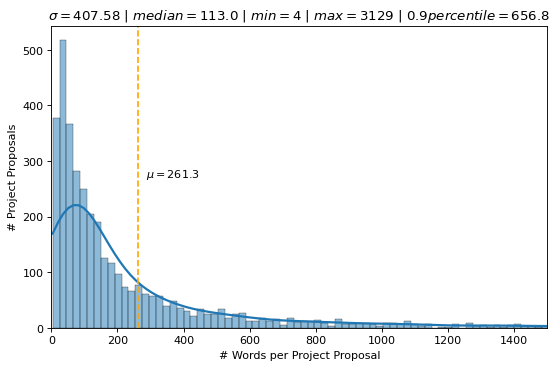

In [22]:
# Distribution of number of words per Project Proposal dataset
input_prj_en['num_words'] = input_prj_en['nltk_tokens_lem'].apply(lambda x: len(x))
plt.figure(figsize=(8,5), dpi= 80)
ax = make_density(df=input_prj_en, color='#1f77b4',x_axis_text='# Words per Project Proposal', y_axis_text='# Project Proposals', bins=150, 
             x='num_words', y=None, kde=True, show_mean=True, show_other=True,show_quant=True, quant_val=0.9)
plt.xlim(0,1500)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\words_per_prj_prop.png")

#### Uni-grams

In [291]:
prj_word_dict = create_ngram_dict(input_prj_en['nltk_tokens_pos_text'])

In [292]:
# Vocabulary size Project Proposals dataset
print('Vocabulary size of Project Proposal dataset: ' + str(len(prj_word_dict)))

Vocabulary size of Project Proposal dataset: 30679


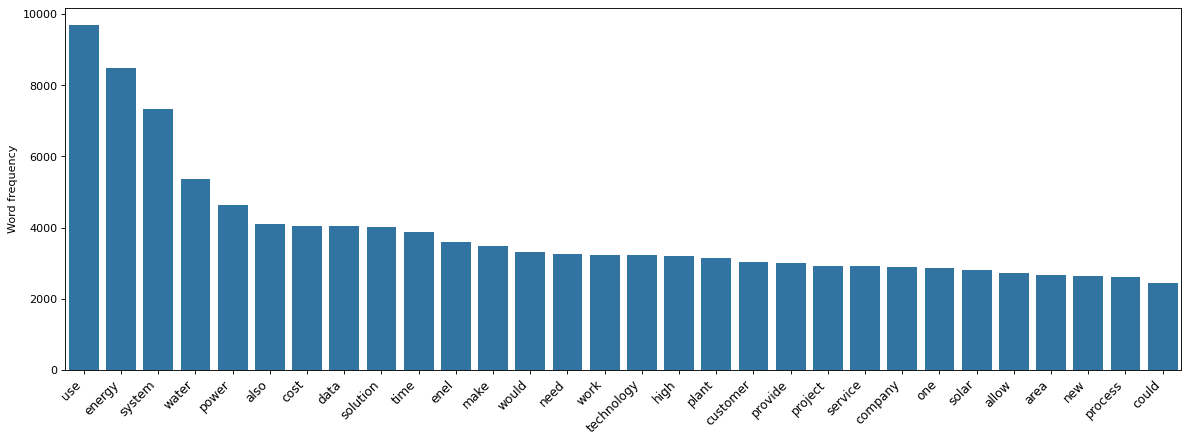

In [293]:
df = pd.DataFrame(list(prj_word_dict.items())[:30],
                             columns=['words', 'count'])
plt.figure(figsize=(18,6), dpi= 80)
ax = sns.barplot(x='words', y='count', data=df,color='#1f77b4')
#plt.xlim(0,4000)
# Plot formatting
ax.set_ylabel("Word frequency")
ax.set_xlabel("")

plt.xticks(rotation=45, ha='right',fontsize=11)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\top_30_freq_words_prj.png")

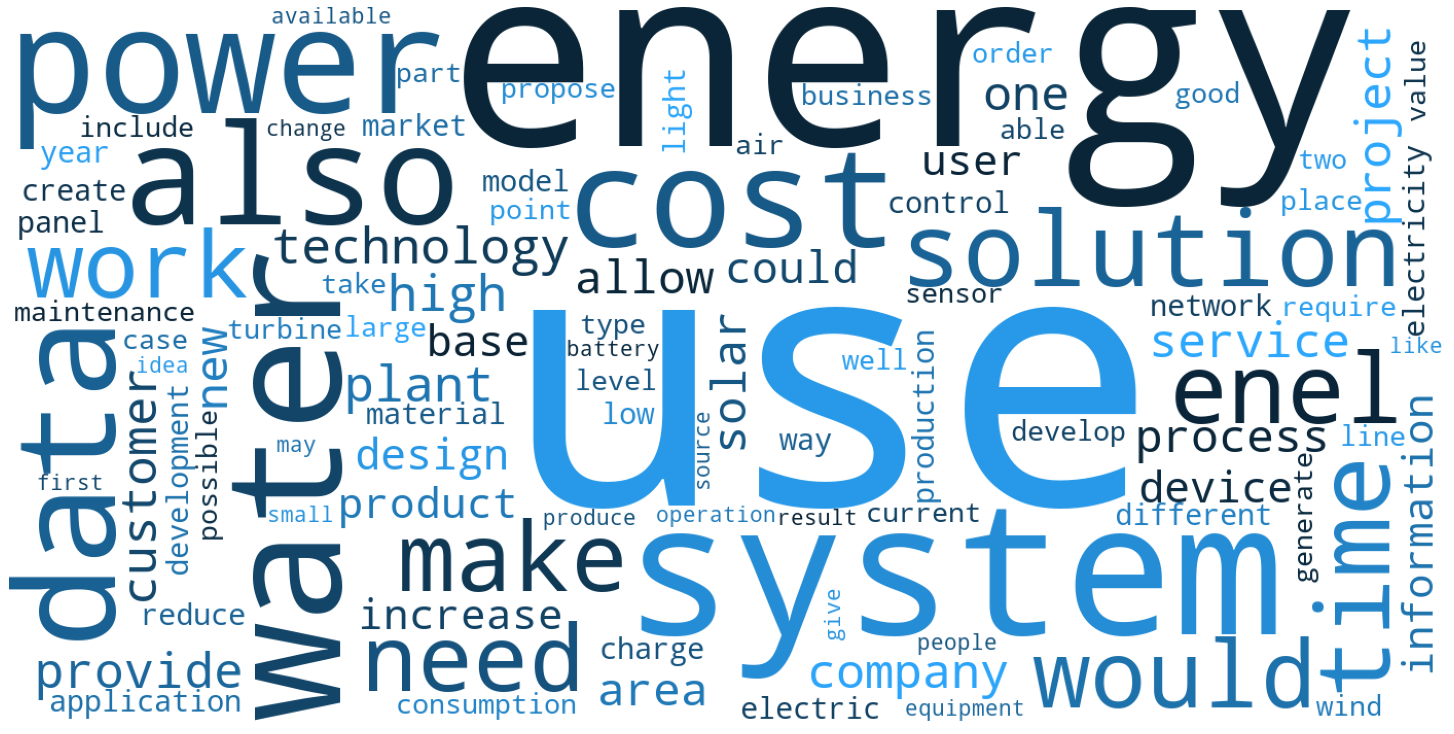

In [294]:
# Create a WordCloud object
wordcloud = WordCloud(width=1400, height=700, background_color="white", max_words=100, contour_width=3,color_func=get_single_color_func('#1f77b4')) #, contour_color='steelblue'
# Generate a word cloud
wordcloud.generate_from_frequencies(prj_word_dict)

# Visualize the word cloud
fig = plt.figure(figsize=(20,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\Wordcloud_prj_words.png")

#### Bi-grams

In [295]:
prj_bigram_dict = create_ngram_dict(input_prj_en['nltk_tokens_pos_text'],2,2)

In [296]:
# Bi-grams vocabulary size Project Proposals dataset
print('Bi-gra vocabulary size of Project Proposal dataset: ' + str(len(prj_bigram_dict)))

Bi-gra vocabulary size of Project Proposal dataset: 550092


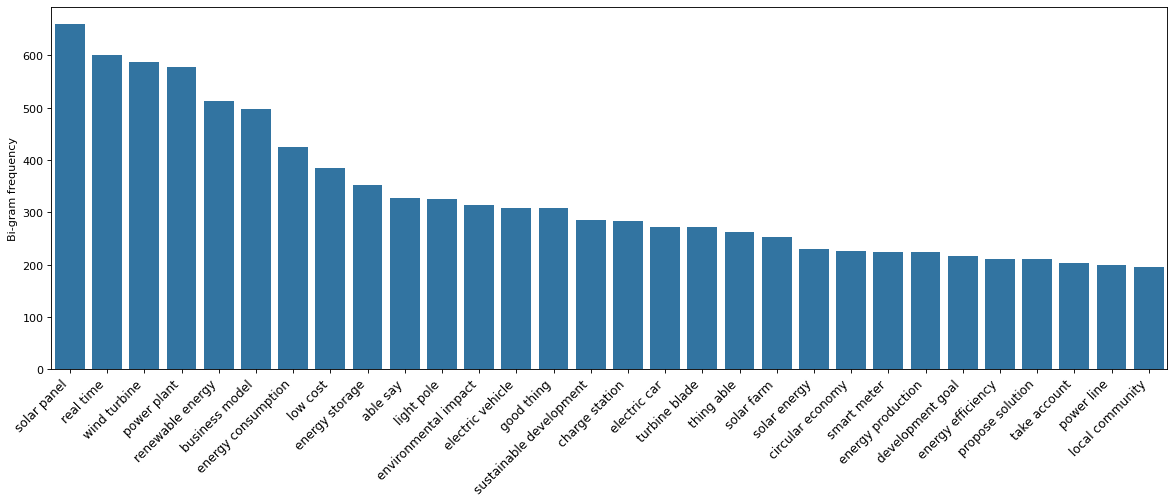

In [297]:
df = pd.DataFrame(list(prj_bigram_dict.items())[:30],
                             columns=['bigrams', 'count'])
plt.figure(figsize=(18,6), dpi= 80)
ax = sns.barplot(x='bigrams', y='count', data=df,color='#1f77b4')
#plt.xlim(0,4000)
# Plot formatting
ax.set_ylabel("Bi-gram frequency")
ax.set_xlabel("")

plt.xticks(rotation=45, ha='right',fontsize=11)
plt.show()
fig = ax.get_figure()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\top_30_freq_bigrams_prj.png")

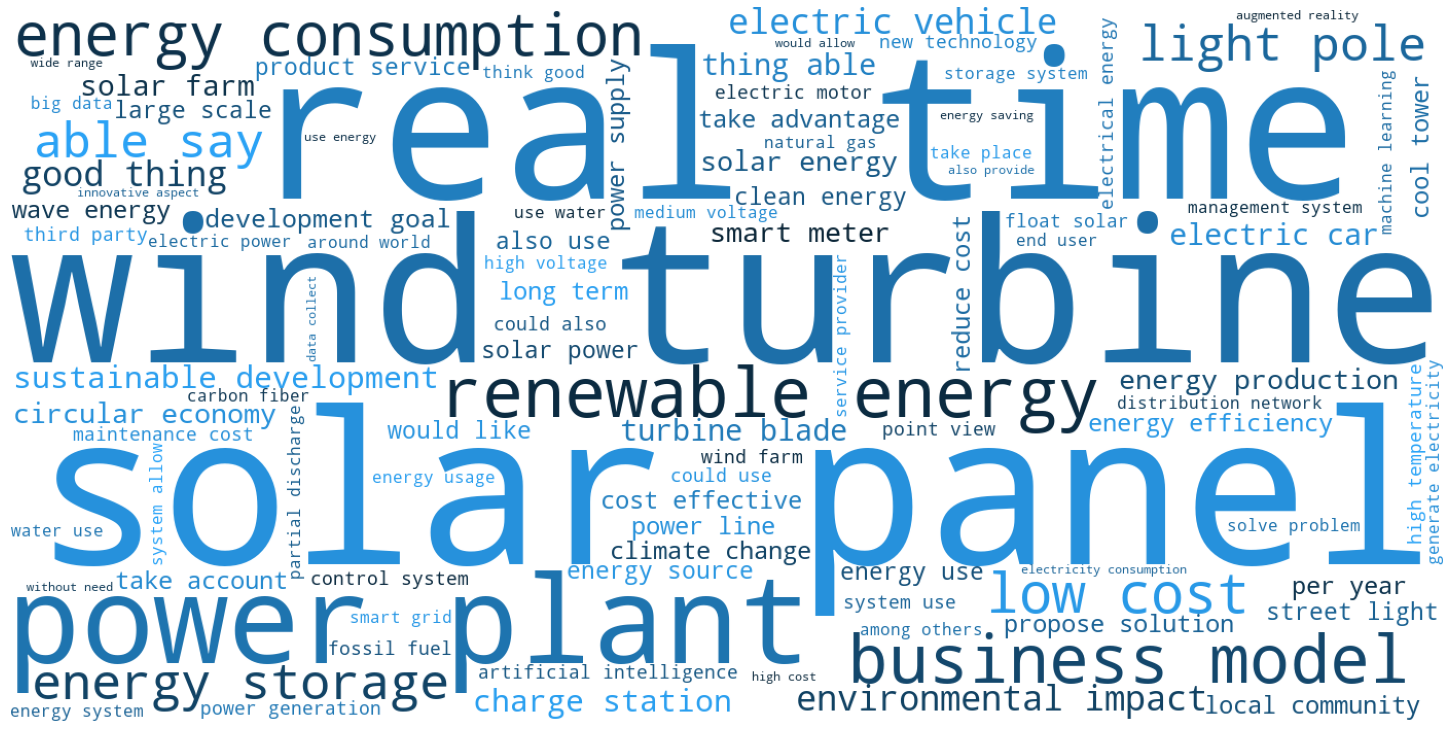

In [298]:
# Create a WordCloud object
wordcloud = WordCloud(width=1400, height=700, background_color="white", max_words=100, contour_width=3,color_func=get_single_color_func('#1f77b4')) #, contour_color='steelblue'
# Generate a word cloud
wordcloud.generate_from_frequencies(prj_bigram_dict)

# Visualize the word cloud
fig = plt.figure(figsize=(20,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\Wordcloud_prj_bigrams.png")

#### Common characteristics Skills and Project Proposals dataset

##### Venn diagrams to show dictionaries overlap

In [299]:
def create_venn(d1, d2, label1, label2, color1 = '#3E64AF', cololor2 = '#3EAF5D'):
    '''Create venn diagrams from two dictionaries.
    Args:
        d1,d2: input sets
        label1,label2: dictionaies' labels
        color1, color2: diagram colors
    '''
    v = venn2([d1, d2], 
          set_colors=('#1f77b4', '#3EAF5D'),  #'#3E64AF'
          set_labels = (label1,label2),alpha=0.8) 
    for text in v.subset_labels:
        text.set_fontsize(9)
    for text in v.set_labels:
        text.set_fontsize(9)
        text.set_color("black")
    venn2_circles([d1, d2], lw=0.7)

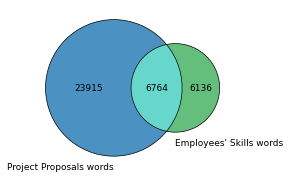

In [302]:
fig = plt.figure(figsize=(6,3))
create_venn(set(prj_word_dict.keys()),set(skills_word_dict.keys()), 'Project Proposals words', 
                    'Employees\' Skills words')
fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\common_words_venn.png')

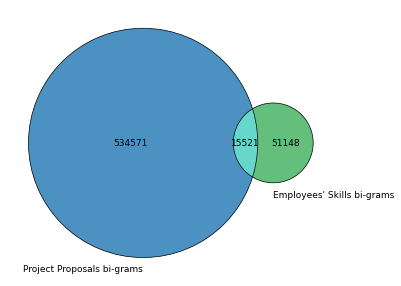

In [61]:
fig = plt.figure(figsize=(8,5))
create_venn(set(prj_bigram_dict.keys()),set(skills_bi_dict.keys()), 'Project Proposals bi-grams', 
                    'Employees\' Skills bi-grams')
fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\common_bigrams_venn.png')

#### Boxplots for number of words per doc, per employee and per skill to emphesize difference among them

In [306]:
# Prepare dataframes for comparative boxplot

# Number of words per Project Proposal
a = input_prj_en[['Solution: Solution Name','num_words']]
a.rename(columns = {'Solution: Solution Name': 'ID'}, inplace = True)
a.loc[:,'Type'] = 'Project Proposal'

# Number of words per Employee
b = skills_empl[['idc_personid_ext','num_words']]
b.rename(columns = {'idc_personid_ext':'ID'}, inplace = True)
b.loc[:,'Type'] = 'Employee'

# Number of words per Skill
c = skills_empl_num[['skill_en','num_words']]
c.rename(columns = {'skill_en':'ID'}, inplace = True)
c.loc[:,'Type'] = 'Skill'

df = pd.concat([a,b,c], ignore_index=True)

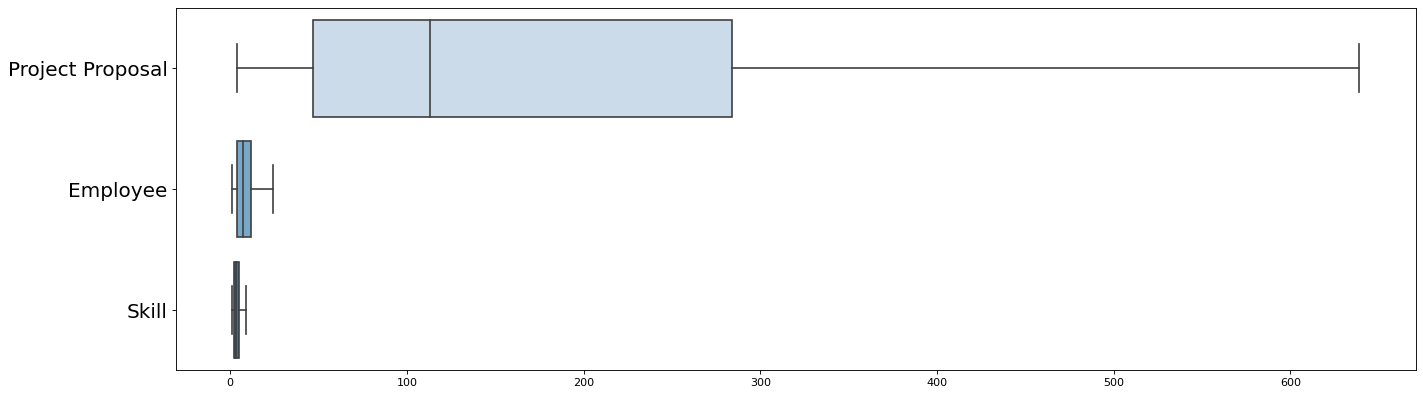

In [313]:
fig = plt.figure(figsize=(20,6),dpi=80)
ax = sns.boxplot(x=df['num_words'], y=df['Type'], order = ["Project Proposal", "Employee", "Skill"], palette = "Blues", showfliers=False)
ax.set_ylabel("")
ax.set_xlabel("")

plt.yticks(fontsize=18)
plt.show()
fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\boxplot_diff_num_words.png")

#### TF-IDF uni-grams

In [2]:
input_prj_en = pd.read_csv('Cleaned_input_text_set_1.csv')

In [3]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\S+',
    ngram_range=(1, 1)
    #max_df=0.7,
    #min_df=0.05
    #max_features=15000
)
vectors = vectorizer.fit_transform(input_prj_en['nltk_tokens_pos_text'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_unigram = pd.DataFrame(denselist, columns=feature_names)

In [272]:
df_unigram.columns

Index(['\aided', 'aaa', 'aabout', 'aae', 'aai', 'aalst', 'aamd', 'aaron',
       'aarys', 'ababa',
       ...
       'école', 'énergies', 'éste', 'óptima', 'óscar', 'össur', 'östfold',
       'últimos', 'über', 'übermittelt'],
      dtype='object', length=30687)

In [97]:
df_unigram.to_csv('D:\\Various documents\\Masters\\Subjects\\Thesis\\uni_set1.csv', index=False)

In [110]:
# Read already generated uni-grams
df_unigram=pd.read_csv('D:\\Various documents\\Masters\\Subjects\\Thesis\\uni_all_words.csv')

In [25]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\S+',
    #token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(2, 2),
    #max_df=0.6,
    min_df=0.01
    #max_features=50000
)
vectors = vectorizer.fit_transform(input_prj_en['nltk_tokens_pos_text'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_bigram = pd.DataFrame(denselist, columns=feature_names)

In [29]:
df_bigram_1 = pd.read_csv('D:\\Various documents\\Masters\\Subjects\\Thesis\\bigrams_set_1_max09_min01.csv')

In [76]:
df_bigram=pd.read_csv('D:\\Various documents\\Masters\\Subjects\\Thesis\\bigrams_set_1.csv')

In [76]:
# for normalazing data setkl
from sklearn import preprocessing  # to normalise existing X
df_bigram_norm = preprocessing.normalize(df_bigram)

### Nearest Neighbors and DBSCAN

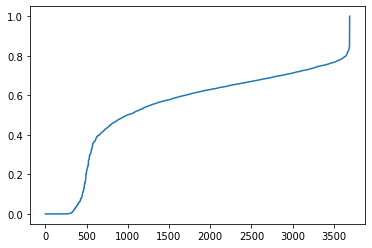

In [12]:
neigh = NearestNeighbors(n_neighbors=3, metric='cosine') #,
nbrs = neigh.fit(df_unigram)
distances, indices = nbrs.kneighbors(df_unigram)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [22]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(eps= 0.01).fit(df_unigram)#,metric='cosine'
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [23]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [24]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df_bigram, labels))

Estimated number of clusters: 46
Estimated number of noise points: 2370
Silhouette Coefficient: 0.155


In [65]:
labels

array([ 0,  0,  0, ...,  0,  0, -1], dtype=int64)

In [25]:
df_bigram['cluster_label'] = pd.Series(labels)

In [28]:
input_prj_en['cluster_label'] = pd.Series(labels)

### Kmeans clustering

In [5]:
def kmeans_model_score(df, N):
    '''Calculates different scores for kmeans model to determine the best number of clusters
        Args:
            df: dataframe of features
            N: max number of clusters
        Return:
            sd: inertia
            km_silhouette: silhouette score
            db_score: Davis Bouldin score
    '''
    sd = []
    km_silhouette = []
    db_score = []
    ch_score = []

    for k in range(5,N):
        model = KMeans(n_clusters=k, init='k-means++', random_state=1981, n_init=10)
        model.fit(df)
        c = model.predict(df)
        
        
        sd.append(model.inertia_)

        silhouette = silhouette_score(df,model.labels_)
        km_silhouette.append(silhouette)

        db = davies_bouldin_score(df,model.labels_)
        db_score.append(db)
        
        ch = calinski_harabasz_score(df,model.labels_)
        ch_score.append(ch)
    scores = {'num_clust':list(range(5,N)), 'sd': sd, 'silhouette': km_silhouette, 'ch': ch_score,'db': db_score}
    scores_df = pd.DataFrame(scores)
        
    return scores_df

In [6]:
def plot_score_kmeans(df, figname):
    '''Visualize and save graph for different model scores for kmeans algorithm.
    
    Args:
        df: dataframe with scores (each column coresponds to one score)
        figname: name of the file
    '''
    
    N = len(df.index)
    # Plot graph
    fig, ax = plt.subplots(4,1,figsize=(10,16))
    sns.lineplot(ax=ax[0], x=df.iloc[:,0],y=df.iloc[:,1], color='#1f77b4')
    sns.lineplot(ax=ax[1], x=df.iloc[:,0],y=df.iloc[:,2], color='#1f77b4')
    sns.lineplot(ax=ax[2], x=df.iloc[:,0],y=df.iloc[:,3], color='#1f77b4')
    sns.lineplot(ax=ax[3], x=df.iloc[:,0],y=df.iloc[:,4], color='#1f77b4')
    #sns.lineplot(ax=ax[2], x=df.iloc[:,0],y=df.iloc[:,3], color='#1f77b4')
 
    ax[0].set_xlabel('# Clusters')
    ax[1].set_xlabel('# Clusters')
    ax[2].set_xlabel('# Clusters')
    ax[3].set_xlabel('# Clusters')
    ax[0].set_ylabel('# Inertia')
    ax[1].set_ylabel('# Silhouette score')
    ax[2].set_ylabel('# Calinski and Harabasz score')
    ax[3].set_ylabel('# Davies Bouldin score')

    #fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\'+figname+'.png')

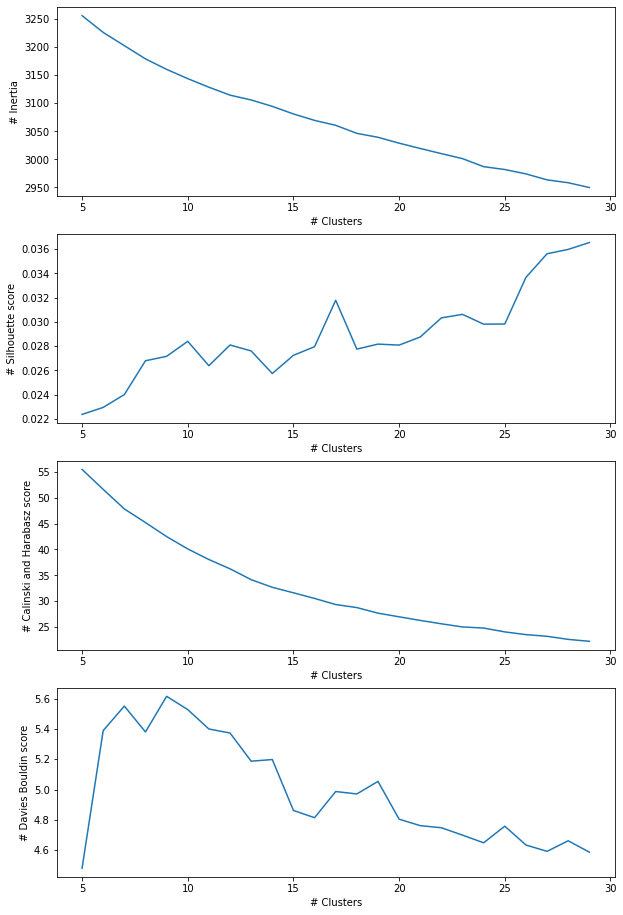

In [28]:
uni_scores_set2 = kmeans_model_score(df_unigram,30)
plot_score_kmeans(uni_scores_set2,'name')

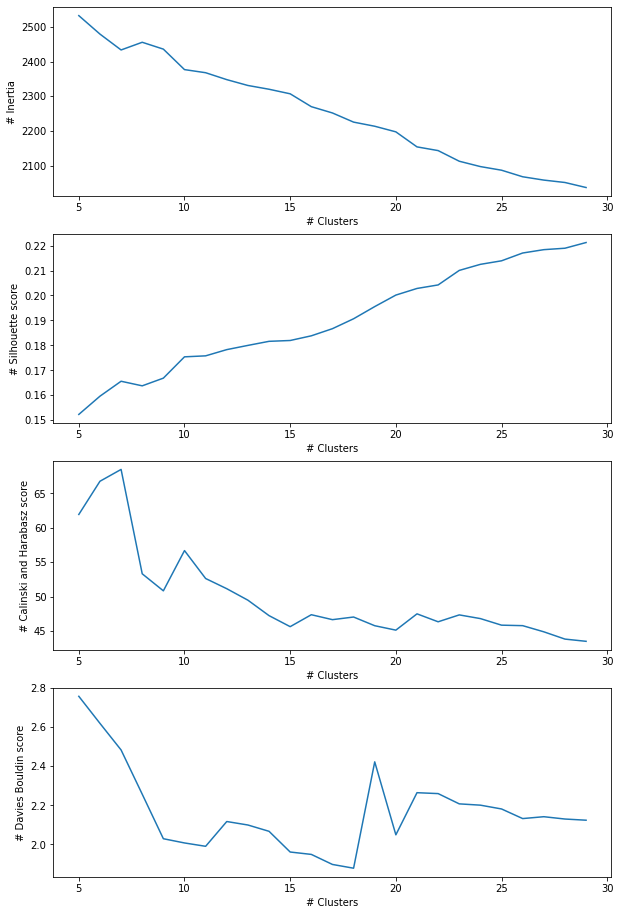

In [30]:
#set 1
bi_scores_set1_ver_min01 = kmeans_model_score(df_bigram_1,30)
plot_score_kmeans(bi_scores_set1_ver_min01,'name')

Text(0, 0.5, '# Documents')

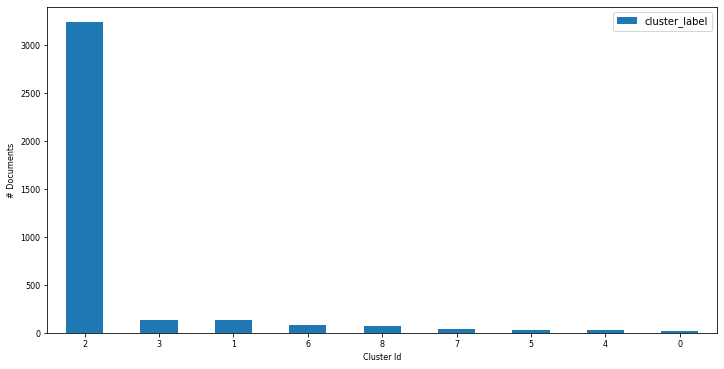

In [78]:
df = make_cluster_kmeans(df_bigram_1,9)
input_prj_en['cluster_label'] = df['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8, rot=0)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [ ]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(15):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust_9 = pd.concat(top_words_list,ignore_index=True)

In [46]:
for i in range(9):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust_9[top_words_clust_9['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: power source, magnetic flux, pyrolytic carbon, valence electron, single phase, power cloud, ferromagnetic material, electron release, control circuit, wave energy, phase power, centenel design, power circuit, sea wave, solaris offgrid, lecture experiment, repulsive diamagnetic, define valence, output power, experiment prof


Cluster 1: solar panel, solar energy, solar farm, solar power, renewable energy, power plant, solar installation, solar cell, grid alternative, photovoltaic panel, local community, solar plant, environmental impact, solar radiation, exist solar, clean solar, cost effective, photovoltaic plant, low cost, surface area


Cluster 2: wind turbine, renewable energy, business model, energy consumption, low cost, energy storage, turbine blade, environmental impact, sustainable development, electric vehicle, smart meter, charge station, circular economy, energy efficiency, development goal, power line, energy production, reduce cost, power plant, wave energy


Cl

In [91]:
#set 2
bi_scores_set1_ver_min01 = kmeans_model_score(df_bigram,30)

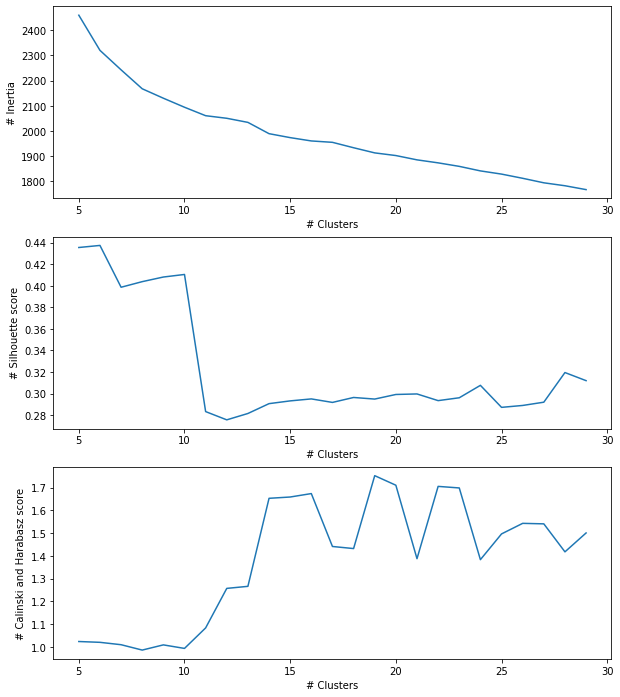

In [92]:
plot_score_kmeans(bi_scores_set1_ver_min01,'name')

Text(0, 0.5, '# Documents')

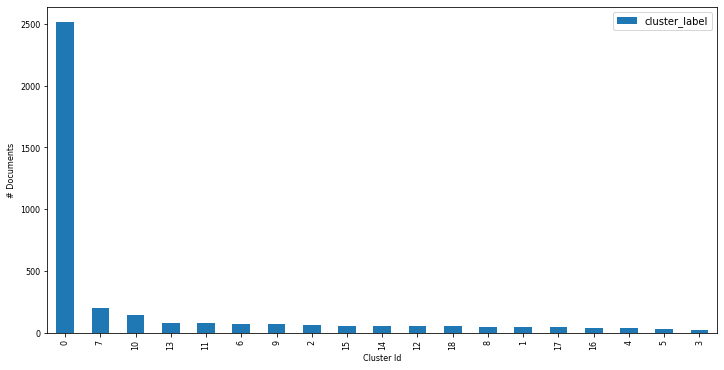

In [101]:
df_bigram['cluster_label'] = make_cluster_kmeans(df_bigram,19)
input_prj_en['cluster_label'] = df_bigram['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [115]:
top_words_clust_19.to_csv('D:\\Various documents\\Masters\\Subjects\\Thesis\\set_2_01_19_clust.csv')

In [117]:
for i in range(19):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust_19[top_words_clust_19['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: electric vehicle, artificial intelligence, long term, natural gas, medium voltage, fossil fuel, electric motor, renewable source, augmented reality, large scale, distribution network, safety distance, generate electricity, solar cell, electricity consumption, mobile phone, machine learning, increase efficiency, air quality, climate change


Cluster 1: electric car, car charge, car park, non electric, charge battery, charge electric, housing unit, charge column, car reach, parking lot, charge area, car battery, battery electric, charge car, electric vehicle, share building, car car, battery station, battery charge, customer journey


Cluster 2: light pole, street light, curved screen, smart light, drone nest, digital fence, mesh network, lighting pole, electric vehicle, air pollution, drone delivery, pole infrastructure, smart pole, curve screen, lcd screen, light display, ultrasonic weaponry, self driving, pole provide, traffic light


Cluster 3: already exist, white stork, 

In [102]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_uni = []
for i in range(19):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_uni.append(top_df)
top_words_clust_19 = pd.concat(top_words_uni,ignore_index=True)


ngram  Freq  cluster_label
20      electric car   106              1
21        car charge    14              1
22          car park    12              1
23      non electric    11              1
24    charge battery     9              1
25   charge electric     8              1
26      housing unit     8              1
27     charge column     8              1
28         car reach     7              1
29       parking lot     7              1
30       charge area     7              1
31       car battery     6              1
32  battery electric     6              1
33        charge car     6              1
34  electric vehicle     6              1
35    share building     6              1
36           car car     5              1
37   battery station     5              1
38    battery charge     5              1
39  customer journey     5              1

In [113]:
top_words_clust_19[top_words_clust_19['cluster_label']==9]

ngram  Freq  cluster_label
180             thing say   130              9
181      question whether    20              9
182         mineral water    19              9
183           whether say    18              9
184             say thing    17              9
185           fiber optic    15              9
186        design network    14              9
187  mediterranean design    13              9
188             place say    11              9
189        internet thing    11              9
190           smart glass    10              9
191            much money     9              9
192           think thing     9              9
193         optical fiber     9              9
194         question much     9              9
195     underground cable     9              9
196       vital parameter     9              9
197   situation situation     9              9
198         family member     9              9
199        remote control     8              9

In [216]:
bi_scores_set1_ver50000 = kmeans_model_score(df_bigram,20)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [7]:
bi_scores_set1 = kmeans_model_score(df_bigram,20)

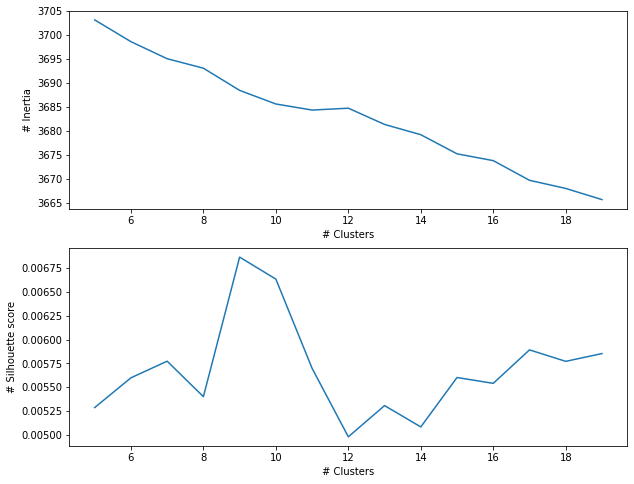

In [8]:
plot_score_kmeans(bi_scores_set1_norm,'name')

In [ ]:
plot_score_kmeans(bi_scores_set1_ver50000,'name')

In [47]:
# Make clusters
def make_cluster_kmeans(input_df,n):
    '''Applies kmeans algorithm for given number of clusters n on input_df and associates each element to one cluster.
    Args:
        input_df: dataframe whose elements should be clustered
        n: number of clusters
    Returns: Cluster prediction for each data point in input_df
    '''
    
    model = KMeans(n_clusters = n, init='k-means++',random_state=1981)
    alldistances = model.fit_transform(input_df)
    C_model = model.predict(input_df)
    
    #totalDistance = np.min(corpus.clusterMatrix, axis=1).sum()
    # Associate documents with clusters
    #cluster_doc = [] #list of tuples which gives the number of document and to which cluster it belongs
    #for i in range(len( model2.labels_)):
    #    cluster_doc.append((i,model2.labels_[i]))   
    res_df = pd.DataFrame(C_model,columns=['cluster_label'])
    return res_df,alldistances

In [11]:
def plot_clust_distr(df, y_label):
    ''' Plot cluster distribution
    Args:
        df: dataframe which should contain column with cluster label information for each data point
        clust_label_col: name of the column which contains cluster label info
        y_label: text which should be used as a label for y-axis
    '''
    df_aggr=df.groupby('cluster_label').value_counts(sort=True).reset_index().rename(columns={'cluster_label':'counts'})
    #df_aggr = pd.DataFrame(index=df.index)
    #df_aggr['counts'] = df.groupby[clust_label_col].value_counts(sort=True)
    plt.figure(figsize=(8,6), dpi= 80)
    ax = sns.barplot(x=clust_label_col, y='counts', data=df_aggr,color='#1f77b4')
    #plt.xlim(0,4000)
    # Plot formatting
    ax.set_ylabel(y_label)
    ax.set_xlabel("Cluster label")

    plt.xticks(rotation=45, ha='right',fontsize=11)
    plt.show()
    fig = ax.get_figure()
    #fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\top_30_freq_bigrams_prj.png")

In [12]:
def get_top_n_ngrams(corpus, wn,n=1,l=1):
    '''Finds top n frequent n-grams.
    Args:
        corpus: input text
        wn: number of top frequent words
        n: lower boundary of the range of n-values for different word n-grams
        l: upper boundary of the range of n-values for different word n-grams
    Returns:
        Top n frequent n-grams
    '''
    vec = CountVectorizer(ngram_range=(n, l)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:wn]

In [13]:
def get_top_n_ngrams_per_clust(df, K, wn, n=1, l=1):
    '''For each cluster findes the most frequent n-grams.
    Args:
        df: input data frame
        K: number of clusters in df
        wn: number of top frequent words
        n: lower boundary of the range of n-values for different word n-grams
        l: upper boundary of the range of n-values for different word n-grams
        
    Returns:
        top_words_clust: data frame of the most frequent n-grams per cluster (dim K x 1)
    '''
    top_words_list = []
    for i in range(K):
        top_words = get_top_n_ngrams(df[df['cluster_label']==i]['nltk_tokens_pos_text'], n=10)
        top_df = pd.DataFrame(top_words)
        top_df.columns=["Unigram", "Freq"]
        top_df['cluster_8_unigram']=i
        top_words_uni.append(top_df)
    top_words_clust_8_uni = pd.concat(top_words_uni,ignore_index=True)

In [ ]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_uni = []
for i in range(8):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_8_unigram']==i]['nltk_tokens_pos_text'], n=10)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Unigram", "Freq"]
    top_df['cluster_8_unigram']=i
    top_words_uni.append(top_df)
top_words_clust_8_uni = pd.concat(top_words_uni,ignore_index=True)

In [233]:
clust_mod_2 = make_cluster_kmeans(df_unigram,2)

TypeError: Index(...) must be called with a collection of some kind, 'cluster_label' was passed

### PCA dimension reduction

In [17]:
def PCA_dim_reduction(df, num_comp):
    pca = PCA(n_components=num_comp,random_state=1981)
    pca_features = pca.fit_transform(df)
    variance_explained = np.cumsum(pca.explained_variance_)
    return pca_features, variance_explained

In [7]:
def SVD_dim_reduction(df, num_comp):
    tsvd = TruncatedSVD(n_components=num_comp,random_state=1981)
    tsvd_features = tsvd.fit_transform(df)
    variance_explained = np.cumsum(tsvd.explained_variance_ratio_)
    return tsvd_features, variance_explained

In [8]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [278]:
def plot_expl_var(var_expl, figname, t=[0.7]):
    '''Visualize and save graph for cumulative variance explained by given number of principal components and 
    mark a point coresponding to a given threshold for cumulative variance.
    
    Args:
        var_expl: list of cumulative variances explained by number of components coresponding to element index
        figname: name of the file
        t: list of thresholds for cumulative variance explained 
    '''
    t_num = len(t)
    N = len(var_expl) #maximal number of components
    
    
    # Plot graph
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(x=range(N),y=var_expl, color='#1f77b4')
    ax.grid(False)
    # Plot threshold points
    for i in range(0,t_num):
        best_N = np.argmax(var_expl>=t[i]) #number of components which explain at least t variance
        ax.scatter(x=best_N, y=var_expl[best_N], color='orange')
        ax.text(best_N+1, var_expl[best_N]-0.04, '$N = {}$'.format(best_N), fontsize=12)
        ax.text(best_N+1, var_expl[best_N]-0.08, '$cum\;\sigma = {}$'.format(round(var_expl[best_N],2)), fontsize=12)
    plt.xlabel('# Components')
    plt.ylabel('Cumulative explained variance')

    fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\'+figname+'.png')

In [29]:
N = 2000 #Number of components
uni_pca_features, uni_var_explain = PCA_dim_reduction(df_unigram, N) 

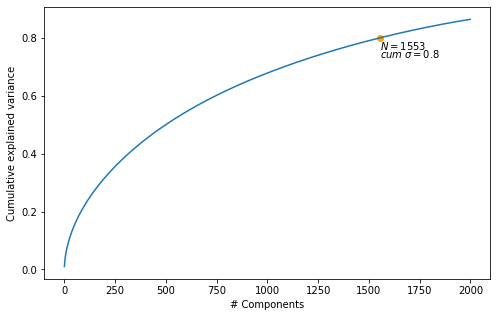

In [100]:
# Explained variance threshold 0.8
plot_expl_var(uni_var_explain, 2000, 'uni_allwords_cum_var', 0.8)

In [ ]:
N = 2000 #Number of components
bi_old_pca_features, uni_var_explain = PCA_dim_reduction(df_unigram, N)

In [17]:
# create SVD reduction for the best N
N = 2500 #Number of components
bigram_old_svd_features, bigram_old_var_explain = SVD_dim_reduction(df_bigram, N)

In [14]:
# create SVD reduction for the best N
N = 2400 #Number of components
unigram_svd_features, unigram_var_explain = SVD_dim_reduction(df_unigram, N)

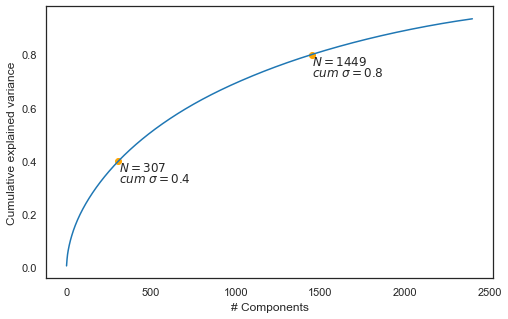

In [279]:
with sns.axes_style('white'):
    plot_expl_var(unigram_var_explain, 'uni_set_2_cum_var_04', [0.4,0.8])

In [155]:
svd_features_sub = unigram_svd_features[:,0:307]

In [317]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # turn off summarization, line-wrapping
with open('D:\\Various documents\\Masters\\Subjects\\Thesis\\unigram_svd_features', 'w') as f:
    f.write(np.array2string(unigram_svd_features, separator=', '))

In [325]:
with open('D:\\Various documents\\Masters\\Subjects\\Thesis\\unigram_svd_features.txt', 'r') as f:
    for line in f:
        for el in line.split():
            print(el)
        break
    #a = [[float(digit) for digit in line.split()] for line in f]

[[
5.11218940e-02,
-2.88544708e-02,
-1.67874212e-02,
-6.95195759e-03,
-3.90046663e-03,
-1.32491385e-02,
-5.71184509e-02,
1.49741559e-02,
-2.40598126e-02,
-6.85004799e-03,
-2.06190908e-02,
-2.22809237e-02,
-5.77794829e-04,
-3.32085767e-02,
5.43100302e-02,
4.33589645e-02,
5.57900641e-02,
-2.02934386e-02,
-1.21799473e-02,
4.51241970e-02,
8.32238635e-03,
2.01128803e-02,
1.38049370e-03,
1.62292509e-02,
-7.57579108e-03,
6.35101303e-03,
1.62078396e-02,
8.00463545e-03,
1.96173643e-03,
1.74101068e-02,
-1.98764674e-02,
-2.23505997e-02,
-3.41061468e-02,
1.99848143e-02,
-5.89593130e-03,
2.40909146e-02,
3.49270665e-02,
-2.47576063e-02,
5.25793095e-03,
3.09934574e-03,
3.65209888e-03,
4.88060871e-02,
-6.57379826e-03,
4.98215872e-02,
2.53582060e-02,
1.73301891e-02,
1.10274158e-02,
-3.61045613e-02,
-6.49678452e-03,
2.35075496e-02,
1.95386444e-02,
1.06175706e-03,
-8.49475074e-03,
-9.57366163e-03,
1.93564671e-02,
-2.14691757e-02,
1.33231195e-02,
3.13170177e-02,
2.72735933e-02,
2.73956459e-03,
-1.12697881

7.70449164e-03,
5.53103737e-03,
1.58005267e-04,
-9.44626188e-05,
2.69354088e-02,
5.17215819e-03,
4.33337712e-03,
7.20284359e-03,
1.47713337e-02,
-5.12902815e-04,
1.03525347e-02,
-2.61814946e-02,
-1.99768695e-02,
1.29028764e-02,
5.81862084e-03,
1.09351779e-02,
-1.89183303e-02,
-2.81542442e-02,
-1.02616197e-02,
2.52244020e-03,
1.83233065e-03,
1.91457030e-03,
-7.83431349e-03,
7.19210730e-03,
-8.17774638e-03,
-2.45809864e-02,
2.30199408e-03,
2.44268285e-02,
3.97125189e-02,
2.67940987e-02,
-1.67628411e-03,
-7.79479188e-04,
-2.78076969e-03,
-2.37521373e-02,
1.73746332e-03,
-2.37359553e-02,
6.35177202e-03,
-3.21236187e-03,
-3.72670134e-03,
-1.20844558e-02,
-2.67183819e-03,
-1.12402065e-02,
5.23431592e-03,
-4.09410890e-03,
-5.69194050e-03,
1.51099379e-03,
1.47308728e-03,
1.13142292e-02,
-6.93489747e-03,
-8.19765655e-03,
-1.65521095e-02,
3.89720553e-03,
-4.94391673e-03,
-1.51942950e-03,
-9.60776025e-03,
1.55676496e-02,
1.43652460e-02,
-2.21525952e-02,
1.55651390e-03,
-9.74765928e-03,
-1.1725583

In [128]:
# create SVD reduction for the best N
#N = 1449 #Number of components
#unigram_svd_features, unigram_var_explain = SVD_dim_reduction(df_unigram, N)#

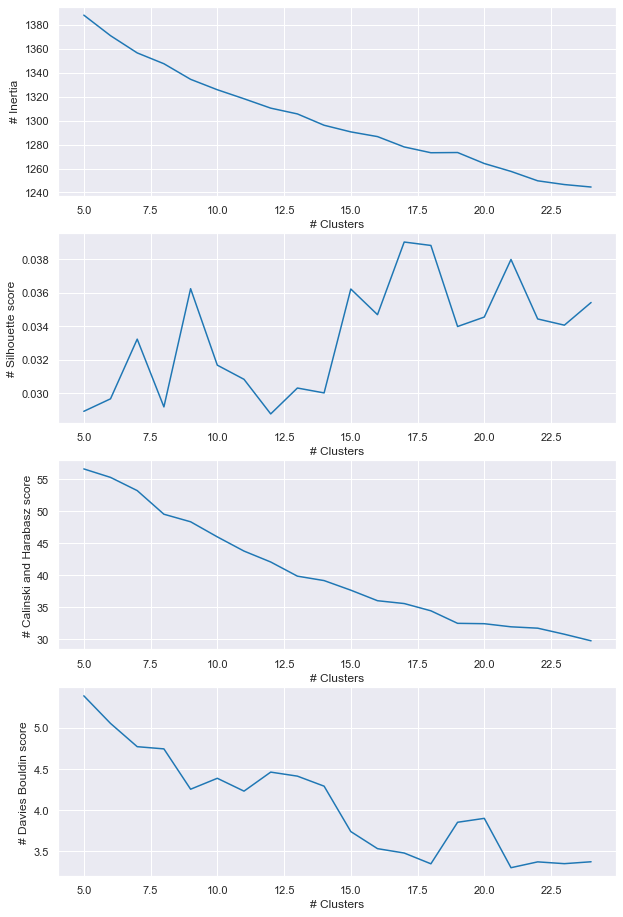

In [156]:
unigram_svd_score = kmeans_model_score(svd_features_sub,25)
plot_score_kmeans(unigram_svd_score,'name')

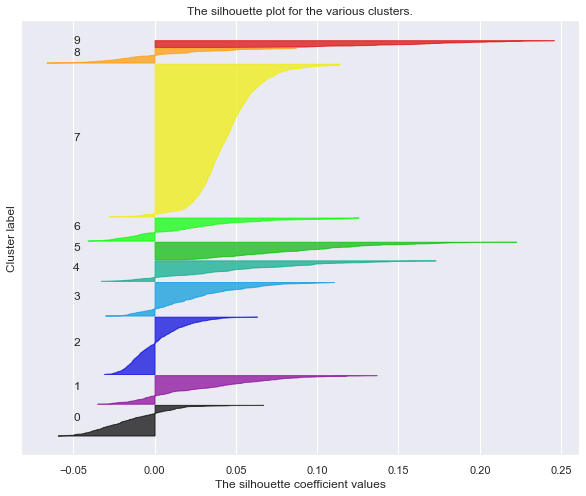

In [249]:
cluster_labels = df_1['cluster_label'].to_numpy()
sample_silhouette_values = metrics.silhouette_samples(svd_features_sub, cluster_labels)
fig, ax1 = plt.subplots(figsize=(10,8))
n_clusters = 10
#fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
#ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
#ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(10):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
#ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
#ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [270]:
unigram_svd_score

num_clust           sd  silhouette         ch        db
0           5  1388.044453    0.028922  56.552017  5.384977
1           6  1370.901189    0.029667  55.231580  5.050762
2           7  1356.512023    0.033227  53.170776  4.768955
3           8  1347.467789    0.029186  49.484550  4.742284
4           9  1334.449780    0.036236  48.306986  4.253795
5          10  1325.762112    0.031675  45.953695  4.386091
6          11  1318.228696    0.030830  43.736981  4.230543
7          12  1310.399394    0.028767  42.033917  4.460991
8          13  1305.568991    0.030311  39.824518  4.412165
9          14  1296.107770    0.030019  39.133717  4.290750
10         15  1290.572106    0.036216  37.637837  3.740829
11         16  1286.633920    0.034685  35.994674  3.534020
12         17  1277.999174    0.039019  35.552587  3.480966
13         18  1273.160995    0.038815  34.420210  3.350532
14         19  1273.339940    0.033980  32.465410  3.853521
15         20  1264.162131    0.034544  32.408091  3.900865
16         21  1257.582392    0.037978  31.923639  3.303227
17         22  1249.728883    0.034431  31.710653  3.373905
18         23  1246.599482    0.034060  30.765754  3.352209
19         24  1244.536872    0.035412  29.739614  3.375156

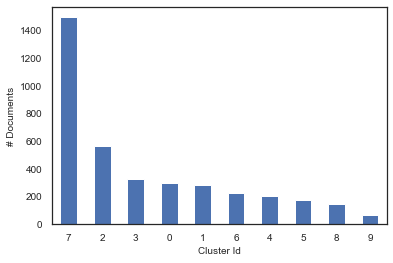

In [310]:
sns.set()
with sns.axes_style('white'):
    df_1, dist_1 = make_cluster_kmeans(svd_features_sub,10)
    input_prj_en['cluster_label_1'] = df_1['cluster_label']

    #Plot cluster distribution
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot()
    input_prj_en['cluster_label_1'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=False, fontsize=10, rot=0)
    ax.set_xlabel("Cluster Id", fontsize=10)
    ax.set_ylabel("# Documents", fontsize=10)
    fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\clusters_10_distr.png')

In [283]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(10):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label_1']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [284]:
for i in range(10):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust[top_words_clust['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: partial discharge, medium voltage, safety distance, electric field, circuit breaker, predictive maintenance, power supply, monitoring system, short circuit, distribution network, low voltage, mobile phone, smart watch, low cost, voltage detector, control center, fiber optic, remote control, fault current, optical fiber


Cluster 1: cool tower, power plant, water flow, water treatment, pump water, water water, drinking water, ram pump, water source, cool water, cooling water, cooling tower, sand filter, flow rate, water quality, water system, lawn grass, clean water, water pump, electric energy


Cluster 2: business model, artificial intelligence, machine learning, sustainable development, big data, development goal, power line, smart meter, low cost, vegetation growth, service provider, social medium, circular economy, environmental impact, augmented reality, data collect, neural network, data collection, air quality, third party


Cluster 3: renewable energy, energy consump

In [295]:
from sklearn.manifold import TSNE
from matplotlib import animation

In [296]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y'] #, 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix

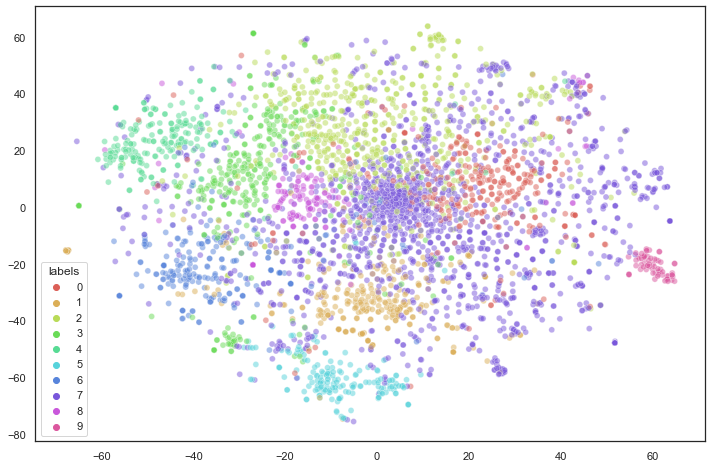

In [316]:
sns.set()
with sns.axes_style('white'):
    tsne_2d_df = prepare_tsne(2, svd_features_sub, df_1['cluster_label'].to_numpy())
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()
    
    sns.scatterplot(
        ax=ax,
        x="x", y="y",
        hue="labels",
        palette=sns.color_palette("hls", 10),
        data=tsne_2d_df,
        legend="full",
        alpha=0.5
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\clusters_10_visual.png')

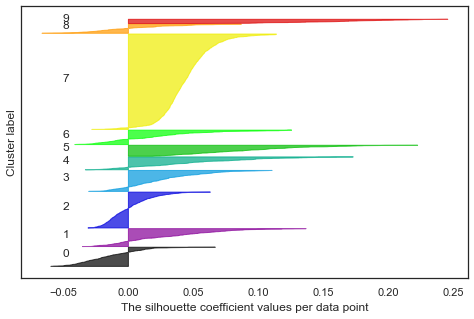

In [269]:
sns.set()
with sns.axes_style('white'):
    cluster_labels_1 = df_1['cluster_label'].to_numpy()
    sample_silhouette_values = metrics.silhouette_samples(svd_features_sub, cluster_labels)
    fig, ax1 = plt.subplots(figsize=(8,5))
    n_clusters = 10
    #fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels_1 == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values per data point")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    fig.savefig('D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\silhouette_coef_clust10.png')

In [183]:
i = 0
for x in input_prj_en[input_prj_en['cluster_label_1']==3].Description:
    i+=1
    print('Project '+str(i)+': '+x+'\n')
    

Project 1: The basic operating principle of a fly-wheel battery is to absorb energy from a source in order to recharge itself, and to store energy in form of kinetic rotational energy that is supplied when needed. The innovative Steel Energy technology is born from the utilization of a special oleo-dynamic support for the fly-wheel suspension (internationally patent protected). The new oleo-dynamic support has allowed the complete review of the operating logics of the battery, setting itself apart from competitors. The oleo-dynamic support allows the rotor to bear significant weights with low energy usage (about 1% of the energy that can be accumulated). The potential increase of the rotor?s weight allows the upwards scalability of the energy that can be stored and at the same time, it allows to keep a relatively low rotation speed (about   rpm), improving the system safety. In this regard reference is made in the CESI studies.

Project 2: The future of the planet is important, and a d

Project 278: Categorize Industries Small, Medium, Large Scale Industries consume energy in different ratios. If we categorize the industries deriving their mode of business eg: if a steel manufacturing industry is consuming 100000Kwh per month, we can assess this data and give a clear prediction and forecasting to new steel industries who are planning to establish. This analysis will help them a lot in fixing the budget. Using those existing big data of track records of our existing clients who are running the same type of industries. Enel can provide accurate forecasting which helps many clients all over the world. Energy consumption This type of data is RAW information of the customers. So our proposed software should track past consumption of energy and predict the future model up to some time period for every customer. If we deliver powerful and accurate forecasting of the energy going to use by the respective customer will increase our business undoubtedly. We also include bar gra

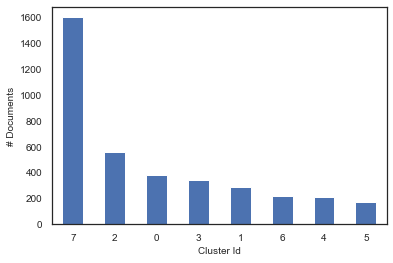

In [280]:
sns.set()
with sns.axes_style('white'):
    df,dist = make_cluster_kmeans(svd_features_sub,8)
    input_prj_en['cluster_label'] = df['cluster_label']
    #Plot cluster distribution
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    
    input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=False, fontsize=10,rot=0)
    ax.set_xlabel("Cluster Id", fontsize=10)
    ax.set_ylabel("# Documents", fontsize=10)
    fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\clusters_8_distr.png")

[]

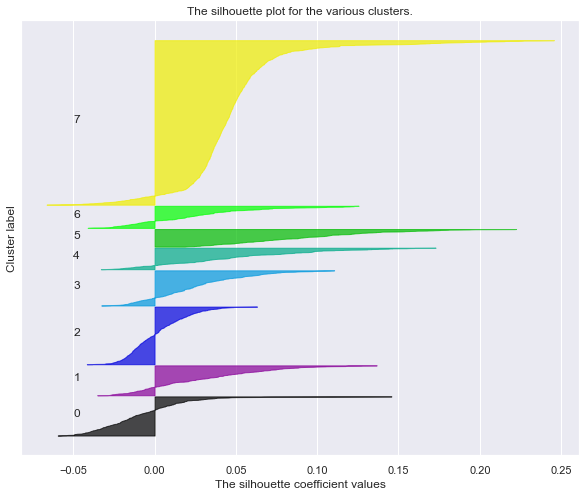

In [241]:
cluster_labels_1 = df['cluster_label'].to_numpy()
sample_silhouette_values = metrics.silhouette_samples(svd_features_sub, cluster_labels)
fig, ax1 = plt.subplots(figsize=(10,8))
n_clusters = 10
#fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
#ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
#ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(8):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_1 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
#ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
#ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [242]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(8):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [243]:
for i in range(8):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust[top_words_clust['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: partial discharge, medium voltage, electric field, safety distance, power supply, predictive maintenance, distribution network, circuit breaker, short circuit, remote control, monitoring system, low voltage, low cost, mobile phone, neural network, control center, smart watch, voltage detector, fiber optic, power line


Cluster 1: cool tower, power plant, water flow, water treatment, pump water, water water, drinking water, ram pump, water source, cool water, cooling tower, cooling water, sand filter, flow rate, water quality, water system, clean water, lawn grass, water pump, electric energy


Cluster 2: business model, light pole, sustainable development, smart meter, machine learning, artificial intelligence, big data, augmented reality, development goal, low cost, social medium, power line, service provider, circular economy, third party, data collect, environmental impact, air quality, data collection, management system


Cluster 3: renewable energy, energy consumption, 

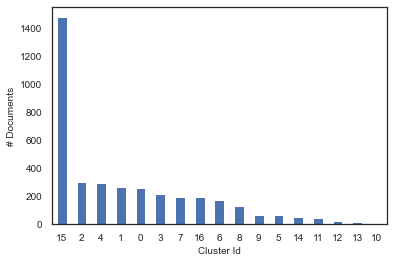

In [281]:
sns.set()
with sns.axes_style('white'):
    df,dist = make_cluster_kmeans(svd_features_sub,17)
    input_prj_en['cluster_label'] = df['cluster_label']
    #Plot cluster distribution
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    
    input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=False, fontsize=10,rot=0)
    ax.set_xlabel("Cluster Id", fontsize=10)
    ax.set_ylabel("# Documents", fontsize=10)
    fig.savefig("D:\\Various documents\\Masters\\Subjects\\Thesis\\Images\\Projects\\clusters_17_distr.png")

[]

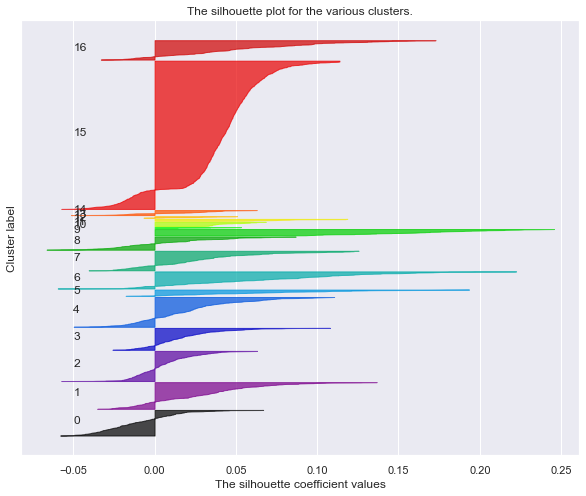

In [256]:
cluster_labels_1 = df['cluster_label'].to_numpy()
sample_silhouette_values = metrics.silhouette_samples(svd_features_sub, cluster_labels)
fig, ax1 = plt.subplots(figsize=(10,8))
n_clusters = 17
#fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
#ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
#ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_1 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
#ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
#ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [257]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(17):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [258]:
for i in range(17):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust[top_words_clust['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: partial discharge, medium voltage, safety distance, electric field, circuit breaker, power supply, short circuit, distribution network, low voltage, mobile phone, predictive maintenance, voltage detector, smart watch, fiber optic, low cost, fault current, optical fiber, monitoring system, remote control, vacuum interrupter


Cluster 1: cool tower, water treatment, power plant, water flow, drinking water, cooling tower, cool water, cooling water, water quality, water system, flow rate, environmental impact, heat exchanger, treatment system, water water, water pump, water purification, pump water, amount water, fresh water


Cluster 2: business model, machine learning, artificial intelligence, big data, vegetation growth, sustainable development, power line, predictive maintenance, air quality, data collect, development goal, data source, neural network, decision making, growth rate, axon vibe, data collection, low cost, environmental impact, management system


Cluster 3: ene

In [171]:
i = 0
for x in input_prj_en[input_prj_en['cluster_label']==6].Description:
    i+=1
    print('Project '+str(i)+': '+x+'\n')
    

Project 1: See attached figure.

Project 2: Please see attached brochure and datasheet. In addition, we can adapt the system to Enel's special requirements regarding special analytics, data presentation, integration with other systems, combination with other information, operational use of the data etc.

Project 3: Please see the attached MSWord file with included graphics.

Project 4: See attached document

Project 5: See attached documents

Project 6: See attached PDFs.

Project 7: Please see attached pdf proposal



Text(0, 0.5, '# Documents')

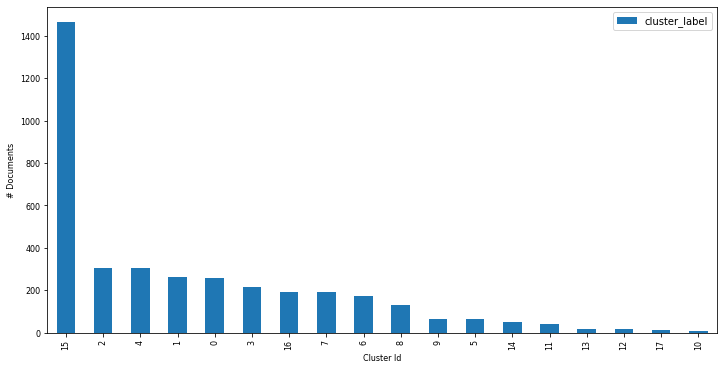

In [30]:
df = make_cluster_kmeans(svd_features_sub,18)
input_prj_en['cluster_label'] = df['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [34]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(18):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [35]:
for i in range(18):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust[top_words_clust['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: partial discharge, medium voltage, safety distance, electric field, circuit breaker, power supply, short circuit, distribution network, low voltage, mobile phone, predictive maintenance, voltage detector, smart watch, fiber optic, low cost, fault current, optical fiber, remote control, data collect, monitoring system


Cluster 1: cool tower, water treatment, power plant, water flow, drinking water, cooling tower, cool water, cooling water, water quality, water system, flow rate, environmental impact, heat exchanger, treatment system, water water, water pump, water purification, fresh water, amount water, water supply


Cluster 2: business model, machine learning, artificial intelligence, big data, vegetation growth, sustainable development, power line, predictive maintenance, air quality, development goal, data source, neural network, service provider, decision making, growth rate, data collect, axon vibe, environmental impact, data collection, management system


Cluster 3:

In [39]:
i = 0
for x in input_prj_en[input_prj_en['cluster_label']==12].Description:
    i+=1
    print('Project '+str(i)+': '+x+'\n')
    

Project 1: Hydraulic ram pumps or simply called as ram pumps are complete automatic device that uses the energy in the flowing water such as spring, stream or river to pump part of the water to a height above that of the source. The pumped water can be returned to the source in order to increase the volume of the source. water The water source with an increased volume can be used to drive an electric generator in return. A meter drop of water can be raised up to 30 meters upward or more. This idea is applicable only in low level or small rivers.

Project 2: Hydraulic Ram Pump, Hydram, or simply Ram Pump is an automatic pumping device that is capable of pumping water higher than its original source without using electricity or any other power source. If we install an array of ram pumps in rivers, streams, waterfalls, etc. to constantly pump water in order to fill an array of water storage tanks installed in forests or in places where there are many trees or plants and/or constantly wet 

In [78]:
# create SVD reduction for the best N
N = 2400 #Number of components
bigram_svd_features, bigram_var_explain = SVD_dim_reduction(df_bigram, N)

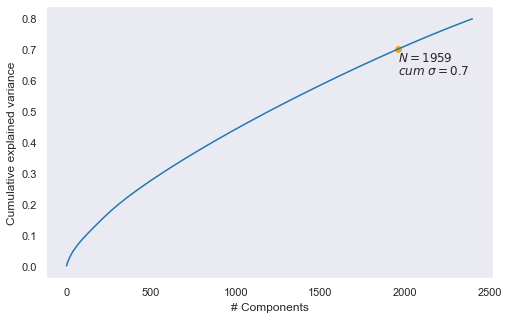

In [277]:
# Explained variance threshold 0.8
plot_expl_var(bigram_var_explain, 'bi_set_2_cum_var', 0.7)

In [108]:
bigram_features_sub = bigram_svd_features[:,:308]

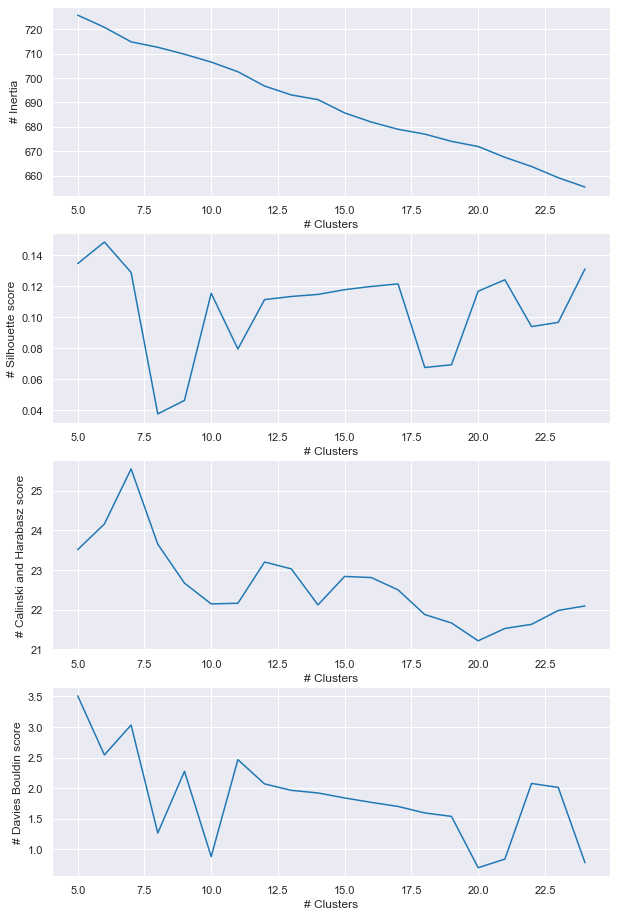

In [109]:
bigram_svd_score = kmeans_model_score(bigram_features_sub,25)
plot_score_kmeans(bigram_svd_score,'name')

In [103]:
bigram_svd_score

num_clust           sd  silhouette         ch        db
0           5  1097.335771    0.023672  16.875580  1.654381
1           6  1092.336470    0.025780  17.012238  1.457845
2           7  1090.351271    0.026622  15.343524  1.318281
3           8  1083.429105    0.032577  16.674025  2.091547
4           9  1082.148961    0.027223  15.160629  2.239650
5          10  1076.701135    0.029524  15.659614  2.080802
6          11  1073.987484    0.020053  15.077577  2.478737
7          12  1072.041703    0.020880  14.349685  2.318918
8          13  1068.805925   -0.001813  14.140320  2.150824
9          14  1064.692250    0.024009  14.218549  2.074041
10         15  1058.697806    0.027970  14.796461  2.103813
11         16  1056.700859    0.028807  14.306539  2.004697
12         17  1054.778637    0.029624  13.861743  1.918276
13         18  1051.538755    0.031070  13.764710  1.847135
14         19  1048.640702    0.032297  13.609756  1.778159
15         20  1044.193953    0.037591  13.787436  2.193150
16         21  1045.895973    0.057074  12.767495  1.748596
17         22  1042.689381    0.020647  12.743855  1.658678
18         23  1038.694249    0.022362  12.864796  1.606614
19         24  1034.039145    0.065115  13.092542  1.538810

Text(0, 0.5, '# Documents')

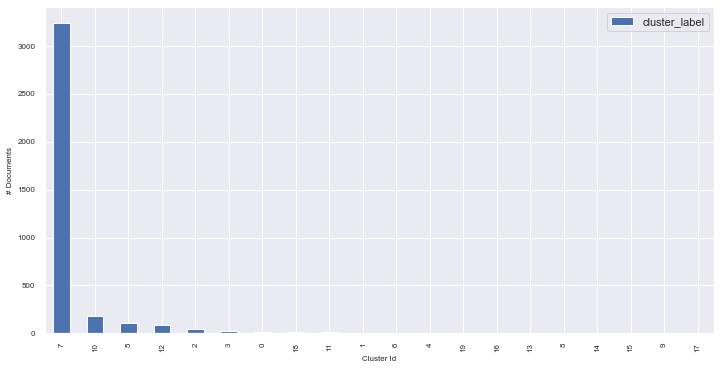

In [106]:
df, dist = make_cluster_kmeans(bigram_features_sub,20)
input_prj_en['cluster_label'] = df['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [45]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(8):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [51]:
input_prj_en['Solution: Solution Name'].count()

3770

In [46]:
i = 0
for x in input_prj_en[input_prj_en['cluster_label']==2].Description:
    i+=1
    print('Project '+str(i)+': '+x+'\n')
    

Project 1: If we can get around one axis. In an oval circuit. Two moving pieces. Let's put it. Relative to the distance created. Between two moving pieces (lever). We will have torque. Torque of the device. Depends on the weight of the moving piece. And the length of the moving piece. Will have . As I've shown in the models.

Project 2: If we can get around one axis. In an oval circuit. Two moving pieces. Let's put it. Relative to the distance created. Between two moving pieces (lever). We will have torque. Torque of the device. Depends on the weight of the moving piece. And the length of the moving piece. Will have

Project 3: If we can get around one axis. In an oval circuit. Two moving pieces. Let's put it. Relative to the distance created. Between two moving pieces (lever). We will have torque. Torque of the device. Depends on the weight of the moving piece. And the length of the moving piece. Will have . As I've shown in the models.

Project 4: If we can get around one axis. In an

In [110]:
bigram_svd_score

num_clust           sd  silhouette        ch        db
0           5  2561.728129   -0.018336  6.322146  7.613601
1           6  2559.072050   -0.018087  5.844830  8.105851
2           7  2556.008389   -0.027414  5.628764  6.150423
3           8  2548.533381   -0.005806  6.417606  5.112211
4           9  2546.545160   -0.005214  5.986229  4.635080
5          10  2542.453912   -0.025213  6.002127  3.592957
6          11  2539.339286   -0.024440  5.869269  3.379299
7          12  2536.717473   -0.023636  5.693739  3.175883
8          13  2533.828628   -0.023226  5.581628  3.295813
9          14  2531.779243   -0.022835  5.389507  3.187196
10         15  2527.902065   -0.013444  5.423247  5.983227
11         16  2523.230405   -0.012701  5.534191  5.861993
12         17  2521.006487   -0.015126  5.398918  6.257472
13         18  2520.349768   -0.013470  5.138954  6.160717
14         19  2518.080378   -0.013125  5.044798  6.014190
15         20  2517.242482   -0.013150  4.845456  5.936787
16         21  2511.549444   -0.011464  5.038311  5.197541
17         22  2509.687217   -0.010940  4.933424  5.125663
18         23  2507.230177   -0.018448  4.879847  5.186736
19         24  2502.234622   -0.018503  5.001694  5.191470

Text(0, 0.5, '# Documents')

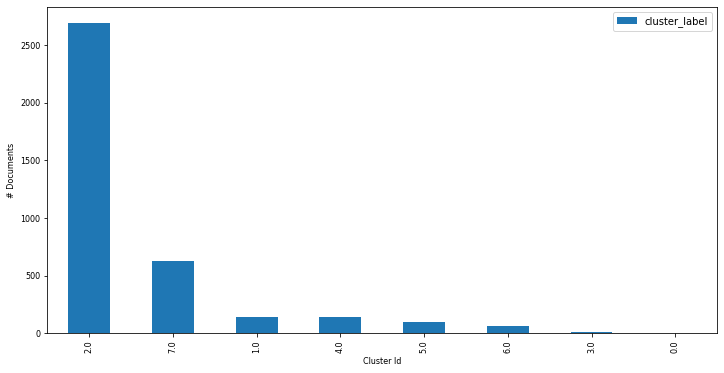

In [199]:
df['cluster_label'] = make_cluster_kmeans(bigram_svd_features,8)
input_prj_en['cluster_label'] = df['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [200]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(8):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [201]:
`

Cluster 0: magnetic flux, pyrolytic carbon, valence electron, ferromagnetic material, electron release, lecture experiment, repulsive diamagnetic, define valence, experiment prof, power source, magnetic domain, linear motion, carbon repulsive, diamagnetic material, domain structure, cool return, magnetic attraction, heat ferromagnetic, iteratively divert, harvesting source


Cluster 1: solar panel, solar farm, solar energy, photovoltaic plant, drought tolerant, renewable energy, lawn grass, solar power, local community, pump water, water source, solar installation, environmental impact, electric motor, grid alternative, solar plant, hydraulic ram, elevated waterway, order prevent, prevent desertification


Cluster 2: low cost, cool tower, power line, medium voltage, power supply, partial discharge, energy consumption, distribution network, energy usage, business model, reduce cost, augmented reality, environmental impact, safety distance, circuit breaker, low voltage, electric field, s

In [204]:
i = 0
for x in input_prj_en[input_prj_en['cluster_label']==2].Description:
    i+=1
    print('Project '+str(i)+': '+x+'\n')
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Project 1422: Surge arrester devices (dischargers) are protective elements typically installed along overheads HV/MV lines, with the purpose of limiting overvoltage transients due to atmospheric events (lightning), circuit breaker opening, etc. They are usually connected between each phase of the line and ground, so that, in case of a transitory overvoltage, they limit the magnitude of the overvoltage discharging an extra-current to ground (up to tens of kA). The lifetime of surge arrester is strongly related to the number and energy (current discharged per overvoltage duration) of transient events which the device has to sustain. Unfortunately, the failure mode of surge arrester is usually in short circuit, causing the outage of the line. For this reason, a system of monitoring and lifetime estimation is crucial in order to prevent surge arrester failure and so, to avoid the outage of MV system. In this project, we propose a low-cost, compact and easy to install device that is able to

In [32]:
# create SVD reduction for the best N
N = 2200 #Number of components
bigram_svd_features, bigram_var_explain = SVD_dim_reduction(df_bigram, N)

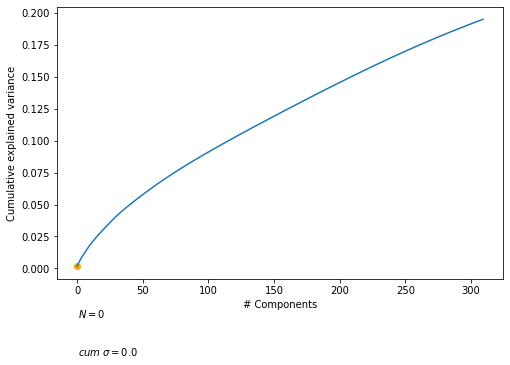

In [78]:
# Explained variance threshold 0.8
plot_expl_var(bigram_var_explain, 'bi_set_2_cum_var', 0.2)

In [45]:
N = 310 #Number of components
bigram_svd_features, bigram_var_explain = SVD_dim_reduction(df_bigram, N)

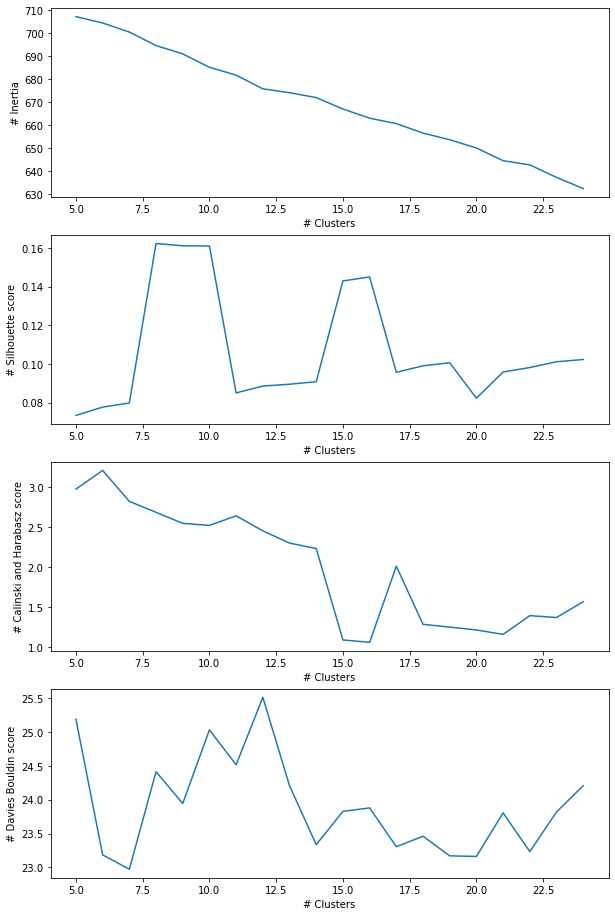

In [46]:
bigram_svd_score = kmeans_model_score(bigram_svd_features,25)
plot_score_kmeans(bigram_svd_score,'name')

Text(0, 0.5, '# Documents')

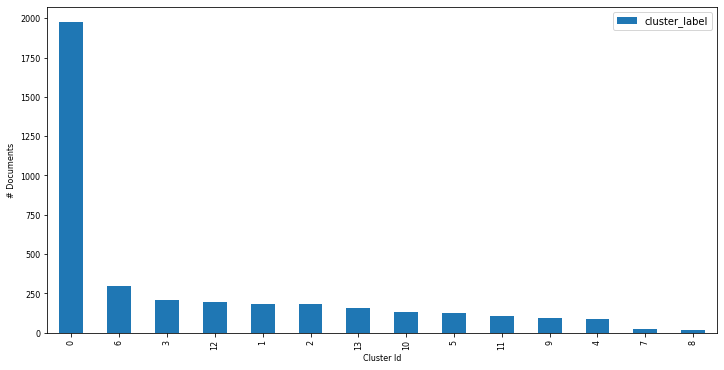

In [71]:
df_bigram['cluster_label'] = make_cluster_kmeans(df_bigram,14)
input_prj_en['cluster_label'] = df_bigram['cluster_label']
#Plot cluster distribution
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
input_prj_en['cluster_label'].value_counts(sort=True).plot(kind='bar',ax=ax, x="Cluster Id", y="# Documents", legend=True, fontsize=8)
ax.set_xlabel("Cluster Id", fontsize=8)
ax.set_ylabel("# Documents", fontsize=8)

In [72]:
#Convert most freq unigrams to dataframe for plotting bar plot
top_words_list = []
for i in range(14):
    top_words = get_top_n_ngrams(input_prj_en[input_prj_en['cluster_label']==i]['nltk_tokens_pos_text'], wn=20, n=2,l=2)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["ngram", "Freq"]
    top_df['cluster_label']=i
    top_words_list.append(top_df)
top_words_clust= pd.concat(top_words_list,ignore_index=True)

In [74]:
for i in range(14):
    print('Cluster ' + str(i)+': '+', '.join(list(top_words_clust[top_words_clust['cluster_label']==i]["ngram"]))+'\n'+'\n' )

Cluster 0: business model, low cost, power supply, smart meter, energy consumption, reduce cost, moving magnet, electric vehicle, environmental impact, renewable energy, solar panel, stator magnet, third party, smart phone, distribution network, light server, solve problem, long term, medium voltage, wind turbine


Cluster 1: get power, web application, vegetation growth, month month, power line, erdas apollo, low cost, growth rate, change detection, public transit, electronic prototype, point cloud, remote sense, lidar data, mobile application, point view, business model, web service, electricity consumption, regional land


Cluster 2: control center, axon vibe, move piece, urban distribution, artificial intelligence, real data, data collection, power line, distribution cabinet, day day, collect data, service provider, reduce cost, surge arrester, data collect, air quality, medium voltage, safety distance, smart meter, low cost


Cluster 3: cool tower, water treatment, geothermal brin

In [96]:
i = 0
for x in input_prj_en.loc[input_prj_en['cluster_label']==11].Description:
    i+=1
    print('Project'+str(i)+'\n'+x)

In [ ]:
uni_scores = kmeans_model_score(uni_pca_features,20)

In [89]:
# create SVD reduction for the best N
N = 200 #Number of components
bigram_set1_svd_features, bigram_set1_var_explain = SVD_dim_reduction(df_bigram, N)

In [90]:
bigram_set1_svd_score = kmeans_model_score(bigram_set1_svd_features,20)

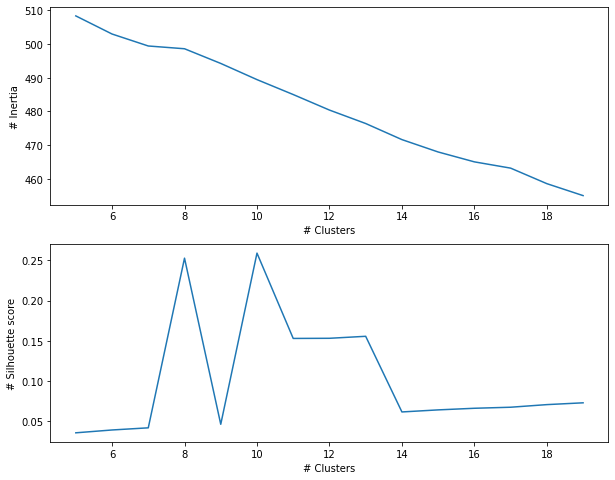

In [91]:
plot_score_kmeans(bigram_set1_svd_score,'name')

In [94]:
clust_mod_10 = make_cluster_kmeans(bigram_set1_svd_features,10)

In [122]:
scores = {'sd': sd, 'silhouette': km_silhouette, 'db': db_score}
scores_df = pd.DataFrame(scores)